### Installing the Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [3]:
import sklearn
import imblearn
print("Scikit-learn version:", sklearn.__version__)
print("Imbalanced-learn version:", imblearn.__version__)

Scikit-learn version: 1.4.0
Imbalanced-learn version: 0.11.0


In [4]:
!pip install imblearn
!pip install -U scikit-learn

In [5]:
from numpy.random import seed
from imblearn.over_sampling import SMOTE

In [6]:
from sklearn.preprocessing import MinMaxScaler

### Importing the dataset

In [70]:
x = pd.read_csv("aps_failure_training_set.csv", skiprows=20, na_values=["na"])
np.random.seed(3482)

In [71]:
x.head(5)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [72]:
print("Shape of the trained dataset:", x.shape)

Shape of the trained dataset: (60000, 171)


### Data Pre_processing

In [73]:
print("Number of train-x points: ", x.shape[0])
print("Number of attributes: ", x.shape[1])

Number of train-x points:  60000
Number of attributes:  171


In [74]:
x['class']

0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
59995    neg
59996    neg
59997    neg
59998    neg
59999    neg
Name: class, Length: 60000, dtype: object

We can see that the class attribute has values negative and positive which is our target variable. The term Positive class consists of component failures due to a specific component of APS and term negative class consists of component failure which is not related to APS. As Class is our `target`variable, we have to convert the string values into integer values.

In [75]:
x['class'] = x['class'].map({'neg':0, 'pos':1})

In [76]:
x['class'].unique()

array([0, 1], dtype=int64)

### Class distribution

Text(0, 0.5, 'count')

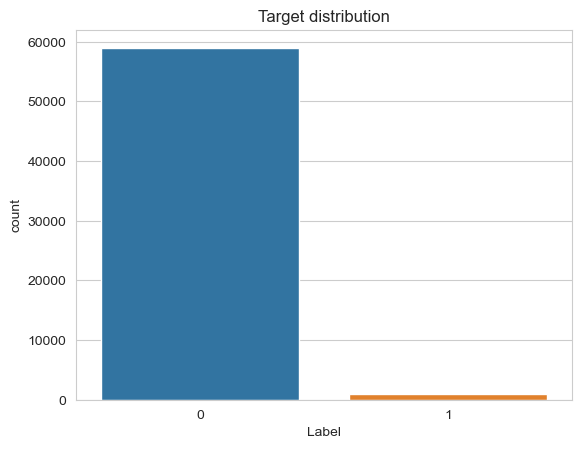

In [77]:
sns.barplot(x['class'].unique(),  x['class'].value_counts())
plt.title('Target distribution')
plt.xlabel('Label')
plt.ylabel('count')

It's clear that the dataset is not equally distributed among the two classes. It has more negative class values than the positive class values. The dataset is highly imbalanced.

### Feature Removal - Standard Deviation

We can remove features whose standard deviation is very low or zero. As these features will have the same values throughout the dataset. It would not help in improving the model. We can define a function constant_value to remove the features. And we found out that, feature cd_000 has a standard deviation of zero.

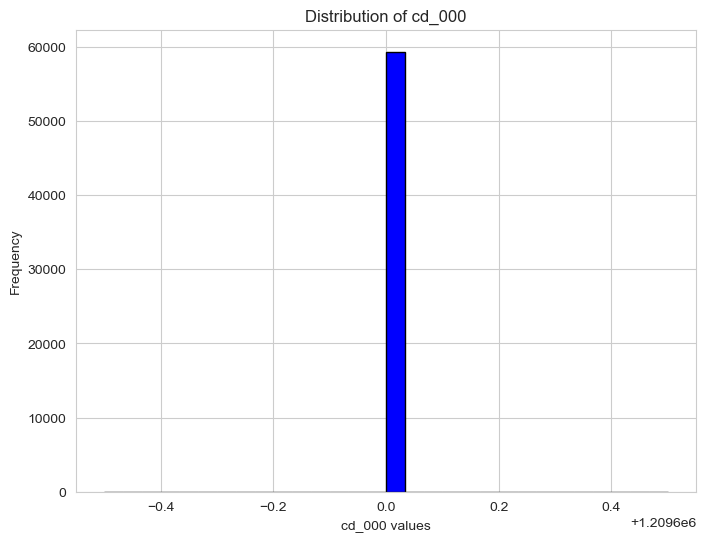

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'x' is your DataFrame and 'cd_000' is the column of interest
# Load the DataFrame if it's not already loaded
# x = pd.read_csv("your_data.csv")

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(x['cd_000'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of cd_000')
plt.xlabel('cd_000 values')
plt.ylabel('Frequency')
plt.show()


In [79]:
def constant_value(df):
  
    constant_value_feature = []
    info = df.describe()
    for i in df.columns:
        if info[i]['std']==0:
            constant_value_feature.append(i)
    df.drop(constant_value_feature,axis=1,inplace=True)
    return df,constant_value_feature

x , dropped_feature = constant_value(x)
print("The features that are dropped due to having a constant value (0 std. dev.) are: ",dropped_feature)
print("Shape of our feature set: ",x.shape)

The features that are dropped due to having a constant value (0 std. dev.) are:  ['cd_000']
Shape of our feature set:  (60000, 170)


Our dataset is known for large number of missing values. We will create a bar plot to check the top attributes with highest percentage of missing values

### Calculation percentage and sorting it in Descending Order

In [58]:
nan_count = {k:list(x.isna().sum()*100/x.shape[0])[i] for i,k in enumerate(x.columns)}
nan_count = {k: v for k, v in sorted(nan_count.items(), key=lambda item: item[1],reverse=True)}

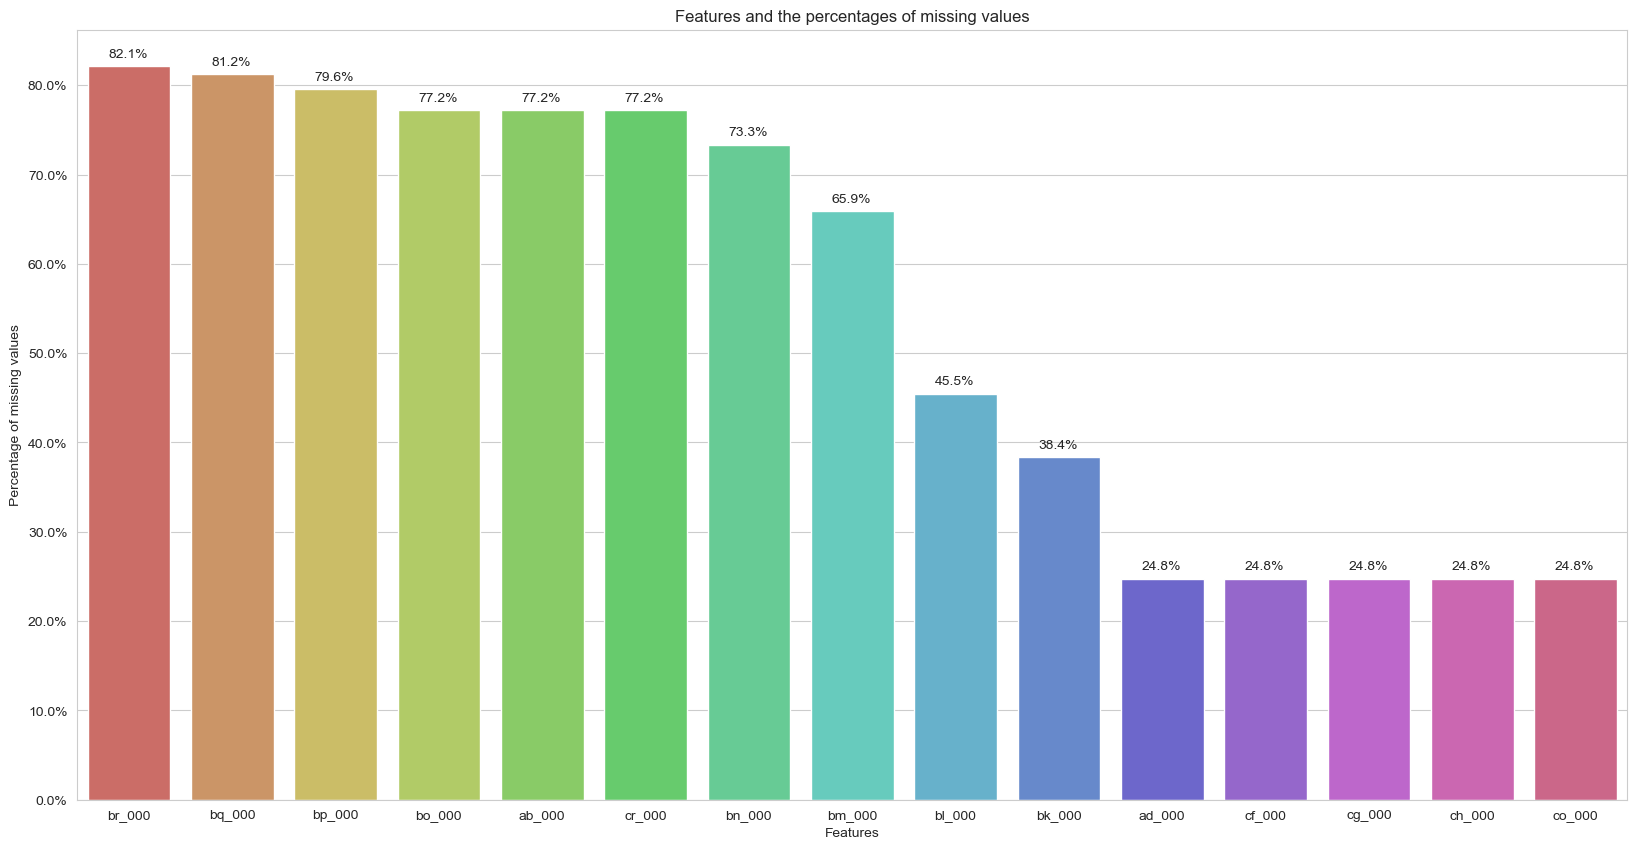

In [59]:
# using seaborn package, we will create barplot to get the features with high number of missing values 
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))


plot = sns.barplot(x= list(nan_count.keys())[:15],y = list(nan_count.values())[:15],palette="hls")


for p in plot.patches:
        plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))


plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs())) 
plt.xlabel("Features")
plt.ylabel("Percentage of missing values")
plt.title("Features and the percentages of missing values")
plt.show()

From the plot, we can observe that br_000, bq_000, bp_000, bo_000,ab_000 cr_000, bn_000 have missing values more than 70 percent.

# Handling missing Data

Removing the columns which have missing values of more than 70 percent values

In [60]:
def remove_na(df,nan_feat):
     
    # Removing features having more than 70 percent missing values
    df = df.dropna(axis = 1, thresh=18000)

    # Removing rows having missing values from above created list of features
    df = df.dropna(subset=nan_feat)

    # Reset Index values 
    df = df.reset_index(drop=True)
    return df

print("Earlier shape of x:",x.shape)

# List of features having less than 5 percent missing values
na_5 = [k for k,v in nan_count.items() if v < 5]

x = remove_na(x,na_5)
print("Shape after removal of rows and columns:",x.shape)
print("Number of features having missing values below 5%:",len(na_5))

Earlier shape of x: (60000, 170)
Shape after removal of rows and columns: (55973, 163)
Number of features having missing values below 5%: 128


Creating a list of the top 7 features having highest number of missing values

In [61]:
na_70 = list(nan_count.keys())[:7]

# Total removed features
removed_features = na_70 + dropped_feature
print("Removed features are:", removed_features)

Removed features are: ['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'cd_000']


Splitting the class attribute from the predictors and saving it as y_train(label)


In [62]:
y_train = x['class']
x_train = x.drop('class',axis=1)

In [63]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
55968    0
55969    0
55970    0
55971    0
55972    0
Name: class, Length: 55973, dtype: int64

For the attributes with missing values between 5 percent and 15 percent we can fill the missing values with mean and for the attributes with missing values ranging from 15 percent to 70 percent, we can fill the missing values with mice imputer. We can make use of the Iterative imputer package from sklearn. We are using ridge regressor as it provides small imputation errors when compared to others.

#### Mean - For the attributes with missing values between 5 percent and 15 percent we can fill the missing values with mean

###### MICE imputer -For the attributes with missing values ranging from 15 percent to 70 percent, we can fill the missing values with mice imputer. 

We can make use of the Iterative imputer package from sklearn. We are using ridge regressor as it provides small imputation errors when compared to others.

In [21]:
def imputation(df,mis_col):
         
    # Using sklearn's SimpleImputer
    mean_imputer = SimpleImputer(missing_values=np.NaN , strategy='mean',copy=True)

    # Creating a new dataframe of imputed values
    mean_df = mean_imputer.fit_transform(df[mis_col])
    df1 = df.copy()
    df1[mis_col] = mean_df

    # Performing Model-Based Imputation
    mice_imputer = IterativeImputer(estimator=Ridge(random_state=0),
                                    random_state=0)
    imputed_df = pd.DataFrame(data = mice_imputer.fit_transform(df1) , columns= df1.columns )

    return imputed_df, mean_imputer, mice_imputer


# List of feature names that have missing values between 5 percent to 15 percent.
# We will impute the missing values in features with their mean
mean_imputed_features = [k for k,v in nan_count.items() if v >= 5 and v < 15]

imputed_x_train, MEAN_imputer, MICE_imputer = imputation( x_train, mean_imputed_features )
print("Number of features whose missing values are imputed with mean are:\n",len(mean_imputed_features))

Number of features whose missing values are imputed with mean are:
 14


In [64]:
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np

def imputation(df, mis_col):
    # Using sklearn's SimpleImputer for mean imputation
    mean_imputer = SimpleImputer(missing_values=np.NaN, strategy='mean', copy=True)

    # Creating a new dataframe of imputed values
    mean_df = mean_imputer.fit_transform(df[mis_col])
    df1 = df.copy()
    df1[mis_col] = mean_df

    # Performing Model-Based Imputation (MICE)
    mice_imputer = IterativeImputer(estimator=Ridge(random_state=0), random_state=0)
    imputed_df = pd.DataFrame(data=mice_imputer.fit_transform(df1), columns=df1.columns)

    return imputed_df, mean_imputer, mice_imputer

# List of feature names that have missing values between 5 percent to 15 percent.
mean_imputed_features = [k for k, v in nan_count.items() if v >= 5 and v < 15]

# Impute the missing values
imputed_x_train, MEAN_imputer, MICE_imputer = imputation(x_train, mean_imputed_features)

# Print the number of features imputed with mean
print("Number of features whose missing values are imputed with mean:", len(mean_imputed_features))
print("Mean Imputed Features:", mean_imputed_features)

# For MICE imputation, the features would be all features excluding the mean imputed ones
mice_imputed_features = [feature for feature in x_train.columns if feature not in mean_imputed_features]
print("Number of features whose missing values are imputed with MICE:", len(mice_imputed_features))
print("MICE Imputed Features:", mice_imputed_features)

Number of features whose missing values are imputed with mean: 14
Mean Imputed Features: ['ak_000', 'ca_000', 'dm_000', 'df_000', 'dg_000', 'dh_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000']
Number of features whose missing values are imputed with MICE: 148
MICE Imputed Features: ['aa_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', '

In [67]:
# Print the number of features imputed with mean
print("Number of features whose missing values are 5% to 15% imputed with mean:", len(mean_imputed_features))
print()
print("Mean Imputed Features:", mean_imputed_features)
print()

# For MICE imputation, the features would be all features excluding the mean imputed ones
mice_imputed_features = [feature for feature in x_train.columns if feature not in mean_imputed_features]
print("Number of features whose missing values are 15% to 70% imputed with MICE:", len(mice_imputed_features))
print()
print("MICE Imputed Features:", mice_imputed_features)
print()

Number of features whose missing values are 5% to 15% imputed with mean: 14

Mean Imputed Features: ['ak_000', 'ca_000', 'dm_000', 'df_000', 'dg_000', 'dh_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000']

Number of features whose missing values are 15% to 70% imputed with MICE: 148

MICE Imputed Features: ['aa_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000

### Loading the Dataset 

In [22]:
x_test = pd.read_csv("aps_failure_test_set.csv",skiprows=20, na_values=["na"])
np.random.seed(3482)

In [23]:
x_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [24]:
print("shape of x_test:",x_test.shape)

shape of x_test: (16000, 171)


We implement the same technique for the test dataset as well.

In [25]:
def preprocess_test_data( x , na_features , mean_features , imputer_mean , imputer_mice):
    # Replace 'neg' and 'pos' with 0,1 in our dataset
    x['class'] = x['class'].replace(['neg','pos'],[0,1])
    
    # Seperate Class label from the rest of the dataset
    y = x['class']
    x = x.drop('class',axis=1)
    
    # Drop Features with high percentage of missing values
    x = x.drop(na_features , axis=1)
    
    x[mean_features] = imputer_mean.transform(x[mean_features])
    
    x = pd.DataFrame(data = imputer_mice.transform(x) , columns= x.columns )
    
    return x,y


x_test , y_test = preprocess_test_data(x_test,
                                       removed_features,
                                       mean_imputed_features,
                                       MEAN_imputer,
                                       MICE_imputer )
print("Shape of Test data:",x_test.shape)

Shape of Test data: (16000, 162)


In [44]:
# Print dropped features
print("Dropped Features due to high missing values more than 70%:", removed_features)
#print("Reason: High percentage of missing values can lead to bias and poor generalization.\n")
print()

# Print mean imputed features
print("Features with Mean Imputation for Missing Values- 5% to 15% :", mean_imputed_features)
#print("Reason: Mean imputation helps handle missing data by maintaining the feature's overall distribution.\n")
print()

# Assuming you want to list all features undergoing MICE imputation (which would be all remaining features after dropping and mean imputation):
mice_imputed_features = [feature for feature in x.columns if feature not in removed_features and feature not in mean_imputed_features]
print("Features with MICE Imputation for Missing values - 15%-70% :", mice_imputed_features)
#print("Reason: MICE imputation handles complex interactions and correlations among features, useful for data not missing at random.")
print()

print("Shape of Test data after missing value removal:",x_test.shape)

Dropped Features due to high missing values more than 70%: ['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'cd_000']

Features with Mean Imputation for Missing Values- 5% to 15% : ['ak_000', 'ca_000', 'dm_000', 'df_000', 'dg_000', 'dh_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000']

Features with MICE Imputation for Missing values - 15%-70% : ['class', 'aa_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_00

### Analysing the features

We define a function to split the histogram features from the numerical features and analyse the features separately

In [27]:
def Identifier_Bin_count(x):
    prefix = [] 
    for name in x.columns:
        prefix.append(name.split('_')[0])
    counter = Counter(prefix)
    return list(counter.keys()),list(counter.values())

feature_prefix , bin_count = Identifier_Bin_count(imputed_x_train)

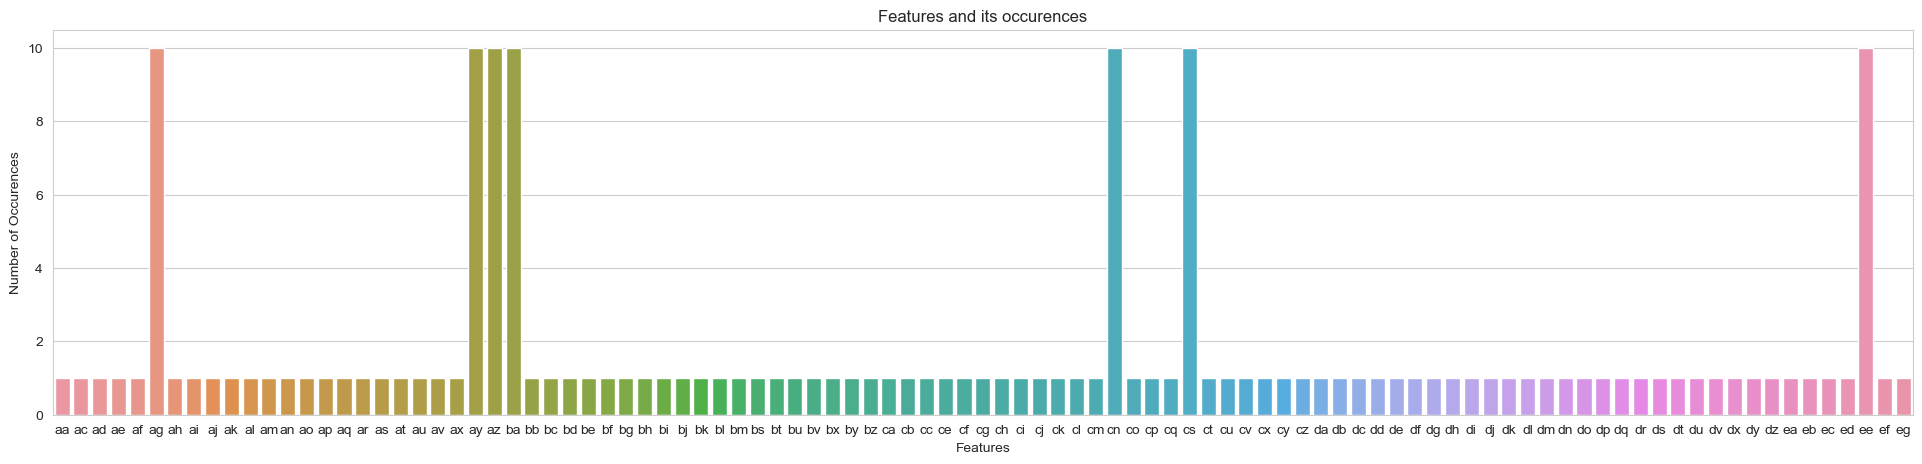

In [22]:
# Plotting the same
plt.figure(figsize=(24,5))
sns.barplot(x = feature_prefix,y = bin_count)
plt.xlabel("Features")
plt.ylabel("Number of Occurences")
plt.title("Features and its occurences")
plt.show()

We can observe that 7 sets of features having 10 bins each. In other words, 7 histograms divided into 10 bins each

In [23]:
# Getting the Identifier of the histogram features
hist_identifier = [feature_prefix[i] for i,j in enumerate(bin_count) if j==10]
print("The Histogram Identifiers are: ",hist_identifier)

# Getting the names of the features having histograms bin information
hist_features = [i for i in x_train.columns if i.split('_')[0] in hist_identifier]
print("\nThere are",len(hist_features),"features that contain histogram bin information and they are: \n",hist_features)

The Histogram Identifiers are:  ['ag', 'ay', 'az', 'ba', 'cn', 'cs', 'ee']

There are 70 features that contain histogram bin information and they are: 
 ['ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006', 'cs_007', 'cs_008', 'cs_009', 'ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009']


We split the histogram data and numerical data and conduct exploratory  data analysis, to know the feature importance 

In [24]:
histogram_data = imputed_x_train[hist_features]
x_without_hist = imputed_x_train.drop(hist_features,axis=1)

We use a recursive feature elimination method wrapped by random forest classifier, to select the top fifteen features from the numerical and histogram features 

In [25]:
def get_top(df,y,n):
    """
    This function returns the top n features,
    by performing Recursive Feature Elimination
    using Random Forest Classifier
    """
    # Use RFE algorithm from sklearn to perform feature selection
    feature_select = RFE(estimator=RandomForestClassifier(n_estimators=150,max_depth=5,random_state=1),
                         n_features_to_select=n,
                         verbose=5)
    feature_select.fit(df,y)
    top_f = [ c for i,c in enumerate(df.columns.tolist()) if feature_select.support_[i] ]   
    return top_f

top_feature_hist = get_top(histogram_data,y_train,15)
print("The top features selected after Recursive Feature Elimination are: \n",top_feature_hist)

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

Creating a dataframe with the top fifteen histogram features and class attribute, but with data which had missing values 

In [26]:
top_features = pd.DataFrame(data=x_train[top_feature_hist],columns=top_feature_hist)
top_features['class'] = y_train
top_features.head()

,ag_001,ag_002,ag_003,ay_005,ay_006,ay_008,ba_002,ba_003,ba_004,cn_000,cn_004,cs_002,cs_004,ee_003,ee_005,class
0,0.0,0.0,0.0,469014.0,4239660.0,755876.0,415432.0,287230.0,310246.0,0.0,1309472.0,267998.0,428776.0,493384.0,469792.0,0
1,0.0,0.0,0.0,71510.0,772720.0,99560.0,199512.0,154298.0,137280.0,0.0,1179502.0,164860.0,272956.0,178064.0,245416.0,0
2,0.0,0.0,0.0,0.0,870456.0,1450312.0,332340.0,254892.0,189596.0,0.0,1215280.0,56362.0,100326.0,159812.0,409564.0,0
3,0.0,0.0,318.0,0.0,0.0,5596.0,304.0,102.0,74.0,0.0,2170.0,24.0,692.0,46.0,44.0,0
4,0.0,0.0,0.0,372236.0,2128914.0,584074.0,338762.0,236540.0,182278.0,0.0,2497104.0,80950.0,186242.0,229790.0,347188.0,0


We define a function plots, which calculates the mean and standard deviation of each class, and plots the Probability Density function, Cumulative Density function and Box-Plot for the given data

Feature 'ag_001' , Class Label 1, Mean: 42503.54
Standard Deviation 232360.91 

Feature 'ag_001' , Class Label 0, Mean: 114.5
And Standard Deviation is 5281.05 


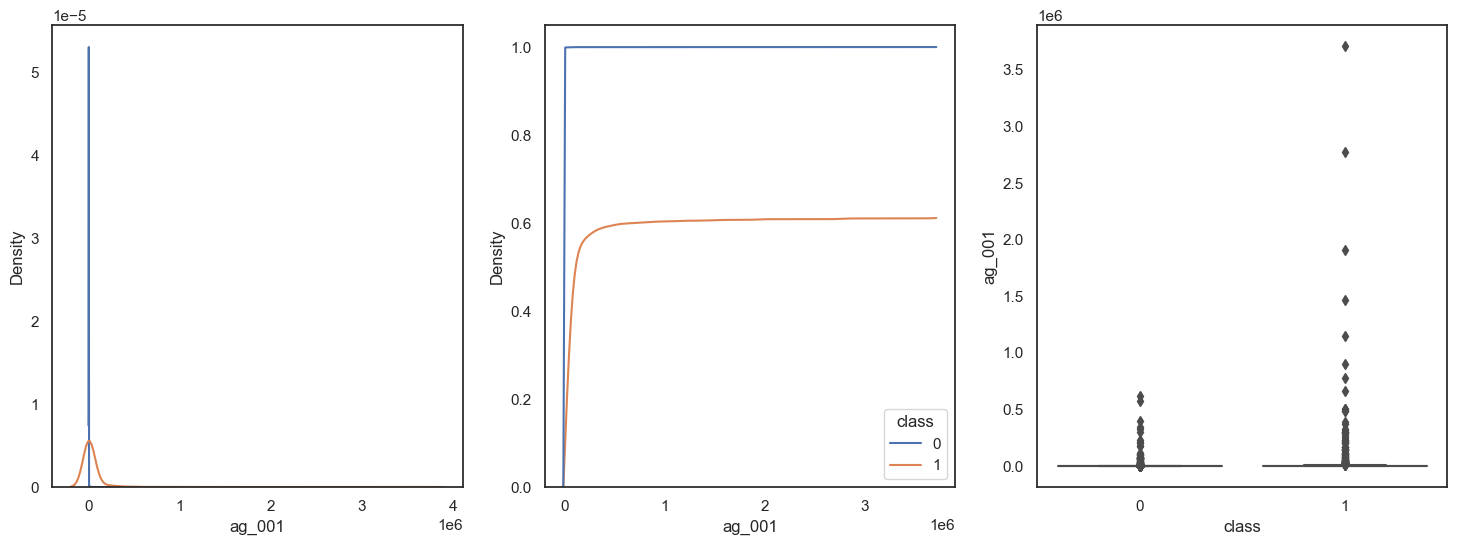

****************************************************************************************************
Feature 'ag_002' , Class Label 1, Mean: 320375.83
Standard Deviation 822733.38 

Feature 'ag_002' , Class Label 0, Mean: 1203.01
And Standard Deviation is 32764.93 


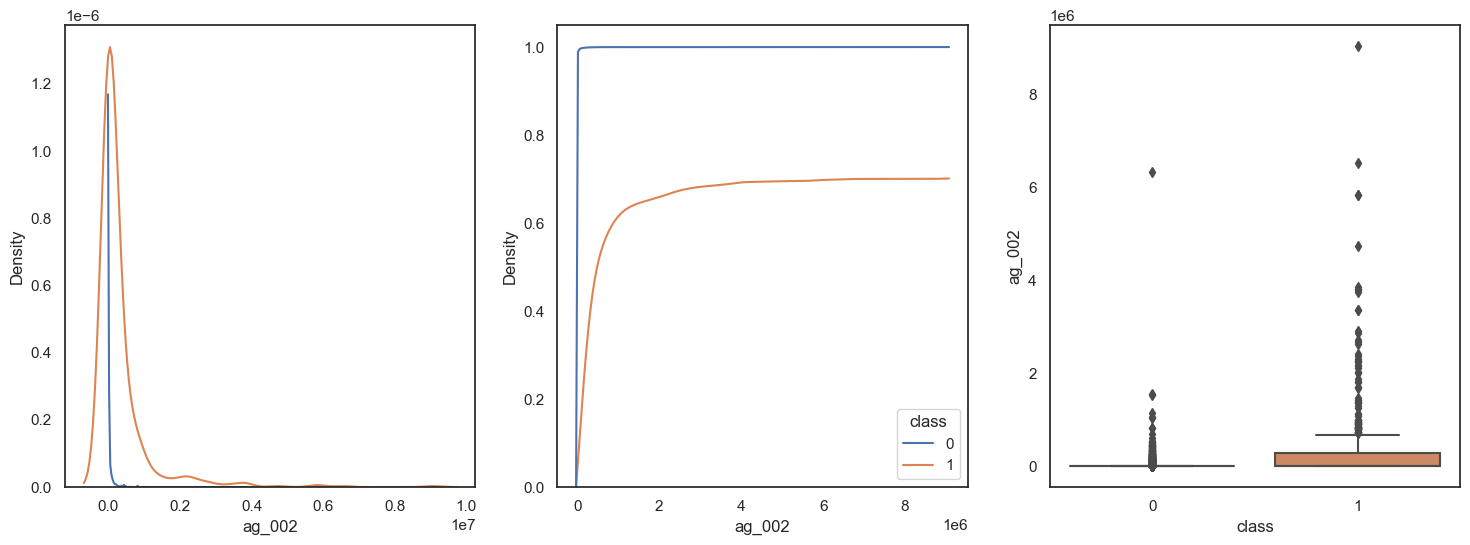

****************************************************************************************************
Feature 'ag_003' , Class Label 1, Mean: 2038674.17
Standard Deviation 3278082.14 

Feature 'ag_003' , Class Label 0, Mean: 29728.63
And Standard Deviation is 351415.59 


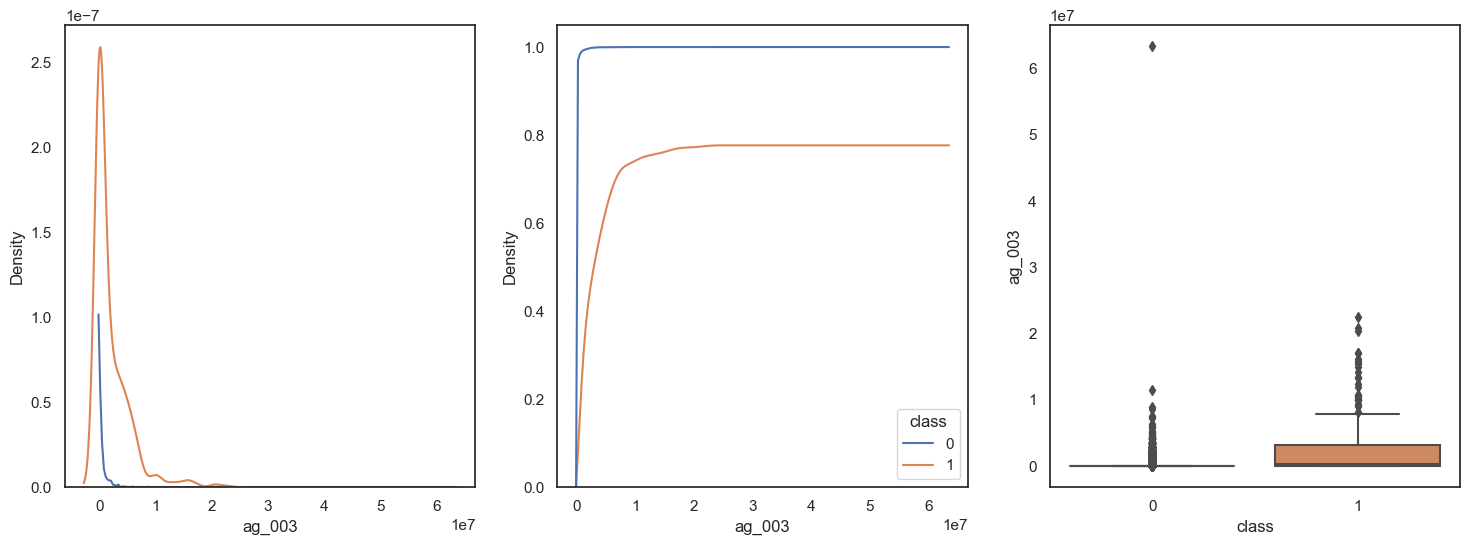

****************************************************************************************************
Feature 'ay_005' , Class Label 1, Mean: 1034242.09
Standard Deviation 4858700.79 

Feature 'ay_005' , Class Label 0, Mean: 54497.11
And Standard Deviation is 535247.53 


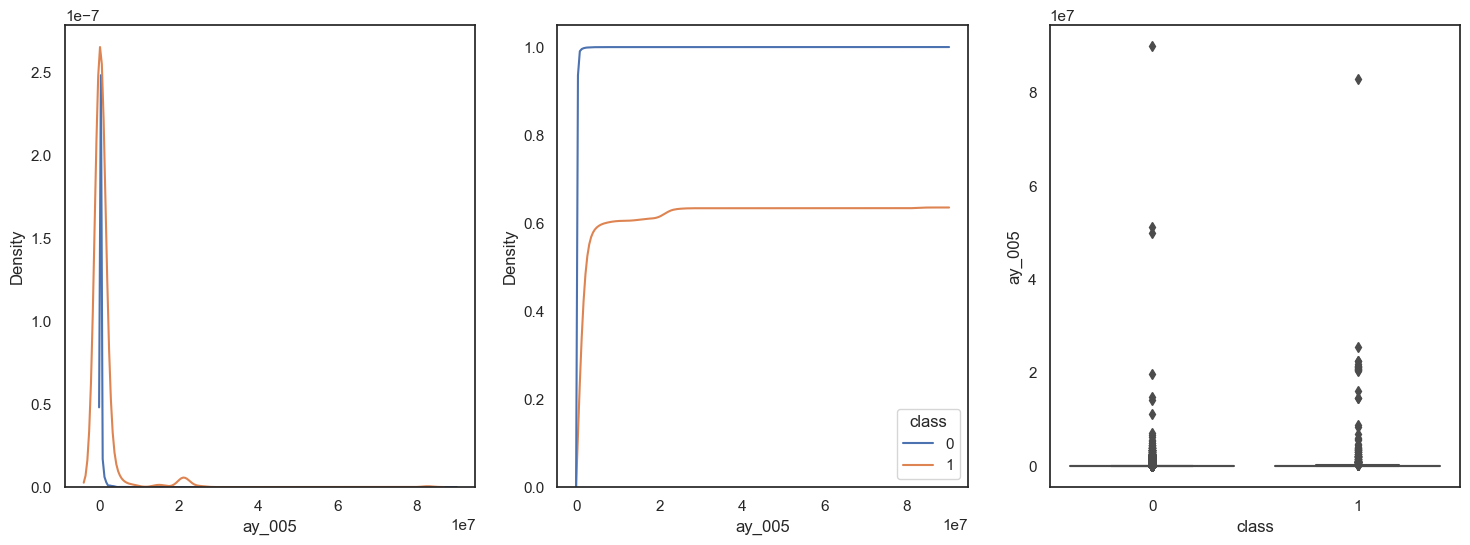

****************************************************************************************************
Feature 'ay_006' , Class Label 1, Mean: 4650066.56
Standard Deviation 10313604.8 

Feature 'ay_006' , Class Label 0, Mean: 886393.89
And Standard Deviation is 1942371.11 


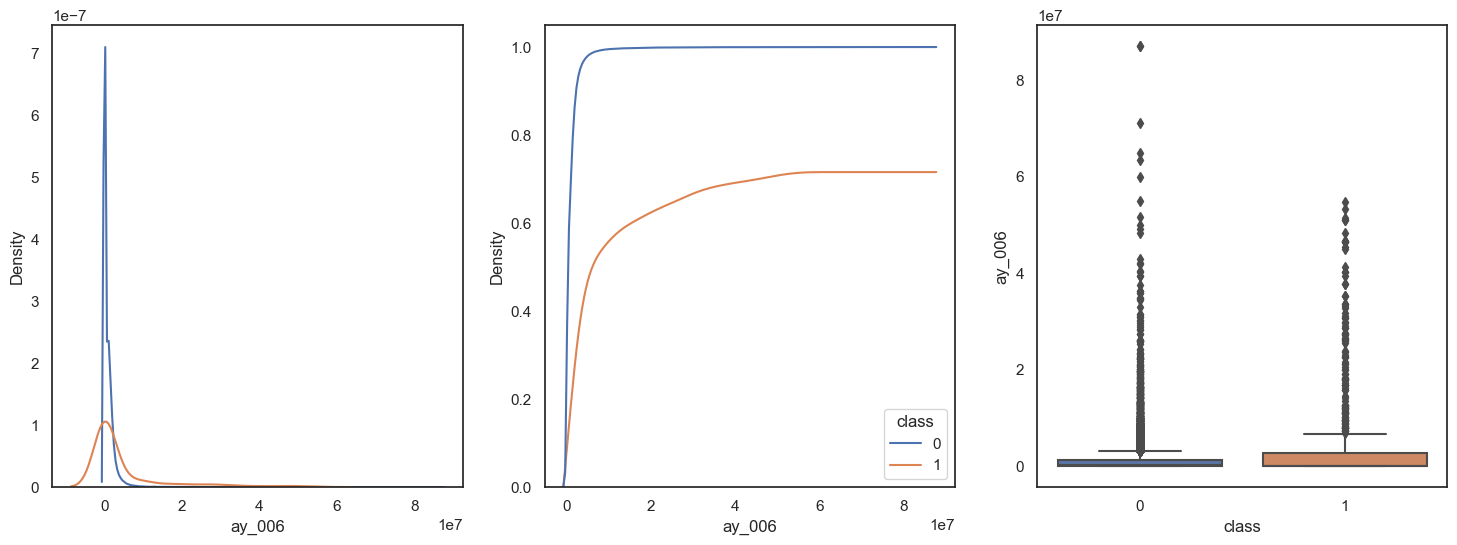

****************************************************************************************************
Feature 'ay_008' , Class Label 1, Mean: 12522092.96
Standard Deviation 14692657.97 

Feature 'ay_008' , Class Label 0, Mean: 669370.15
And Standard Deviation is 2232769.33 


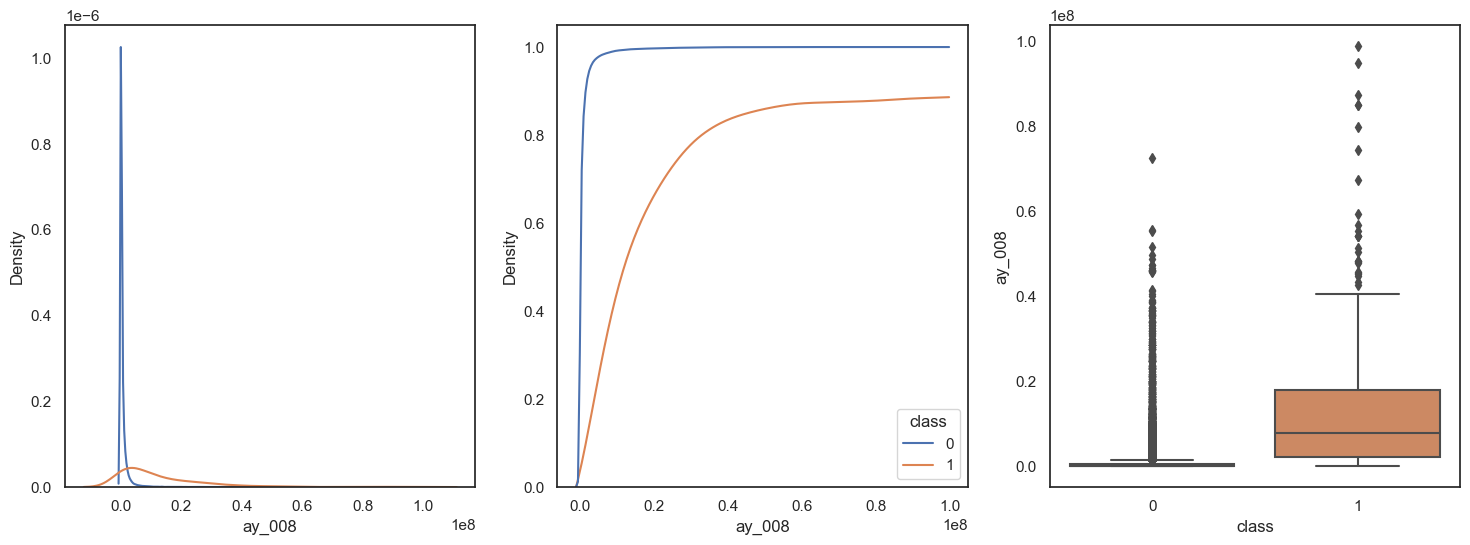

****************************************************************************************************
Feature 'ba_002' , Class Label 1, Mean: 3117128.09
Standard Deviation 2908748.3 

Feature 'ba_002' , Class Label 0, Mean: 275677.46
And Standard Deviation is 645388.32 


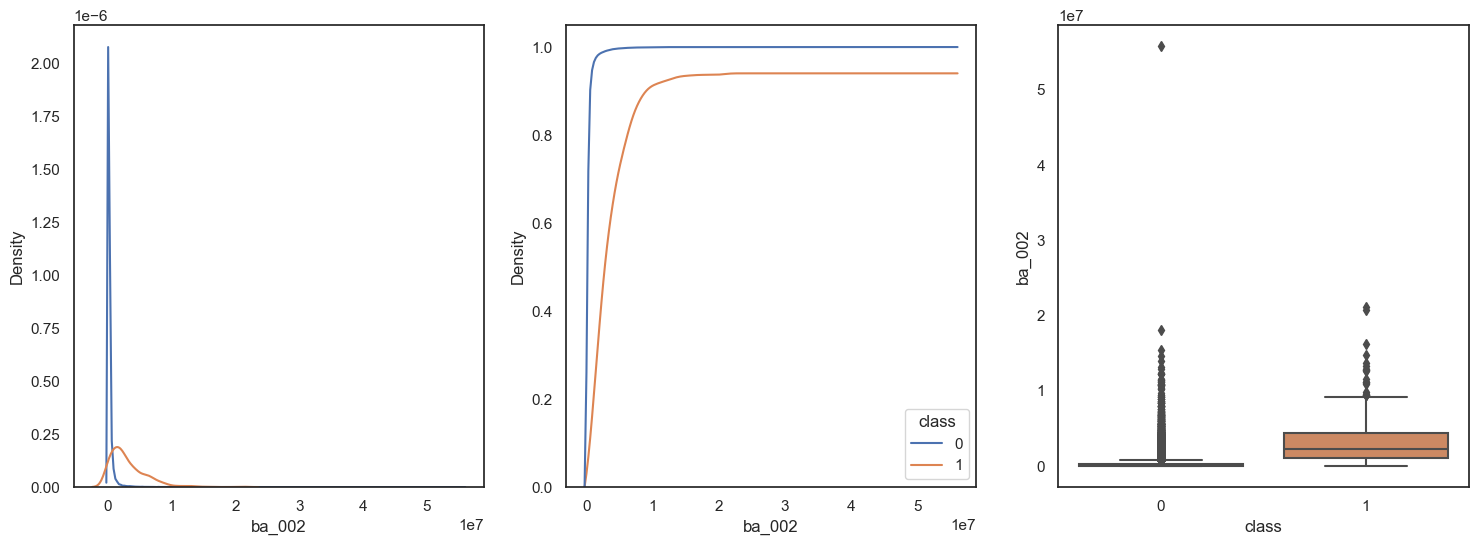

****************************************************************************************************
Feature 'ba_003' , Class Label 1, Mean: 2099777.07
Standard Deviation 1947424.14 

Feature 'ba_003' , Class Label 0, Mean: 187948.58
And Standard Deviation is 397302.96 


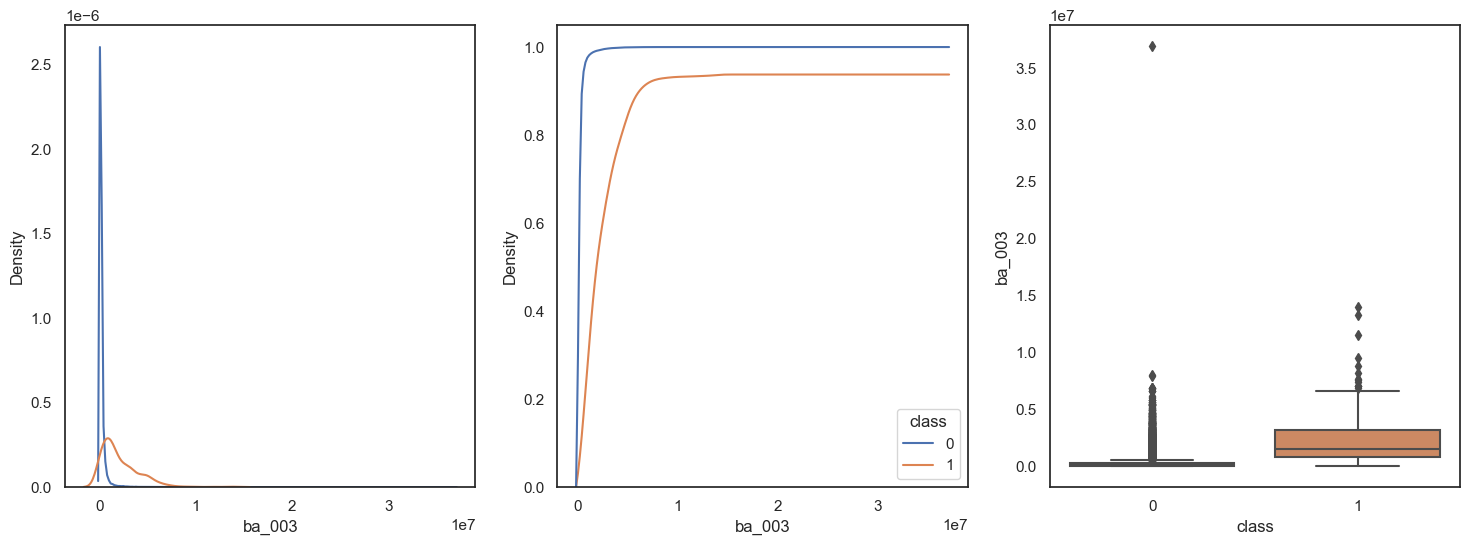

****************************************************************************************************
Feature 'ba_004' , Class Label 1, Mean: 1571623.13
Standard Deviation 1522554.8 

Feature 'ba_004' , Class Label 0, Mean: 144615.66
And Standard Deviation is 288026.2 


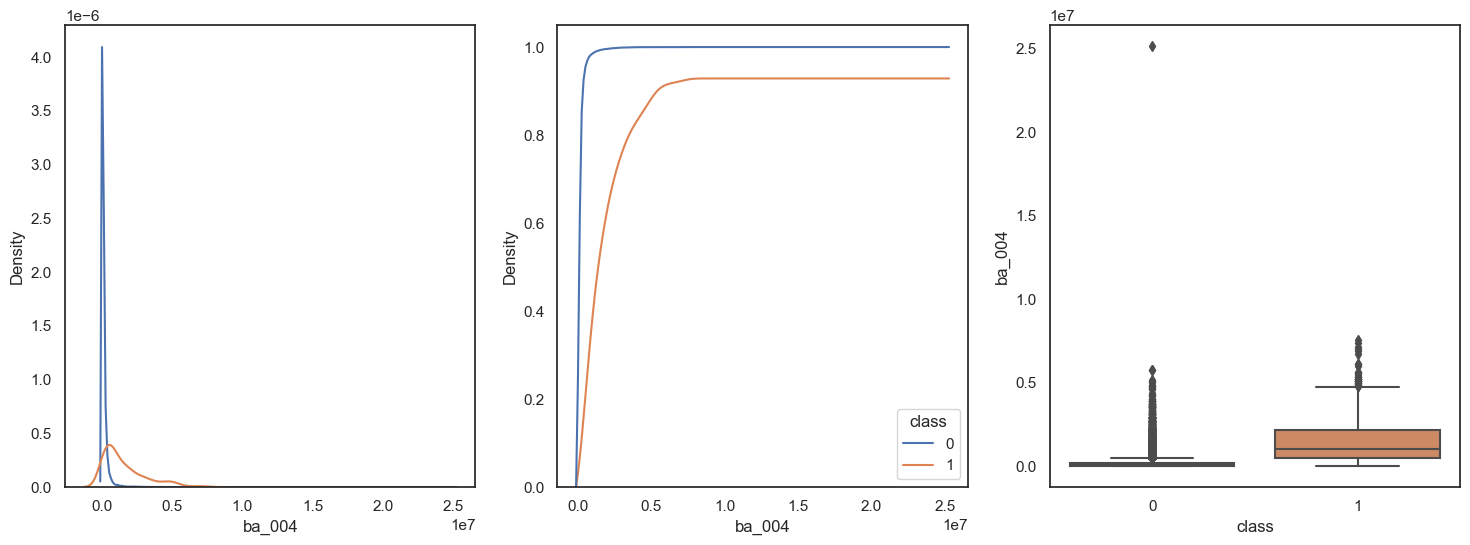

****************************************************************************************************
Feature 'cn_000' , Class Label 1, Mean: 116715.71
Standard Deviation 471065.04 

Feature 'cn_000' , Class Label 0, Mean: 410.59
And Standard Deviation is 17339.97 


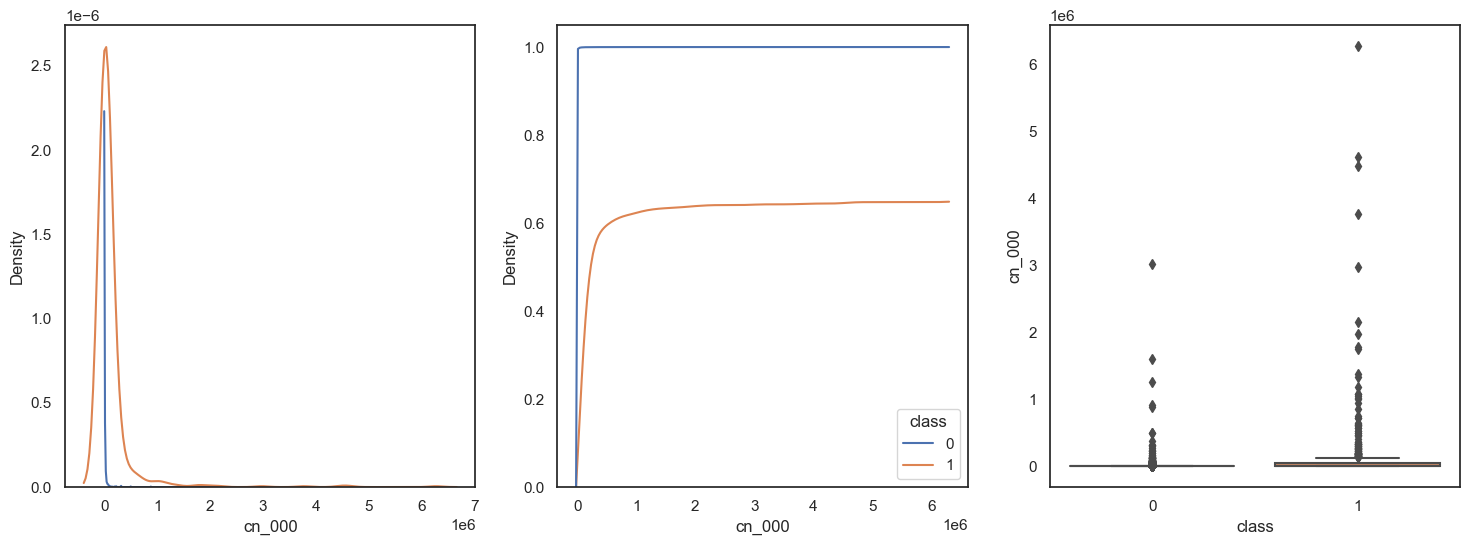

****************************************************************************************************
Feature 'cn_004' , Class Label 1, Mean: 9901680.81
Standard Deviation 10102304.72 

Feature 'cn_004' , Class Label 0, Mean: 900314.56
And Standard Deviation is 1907121.93 


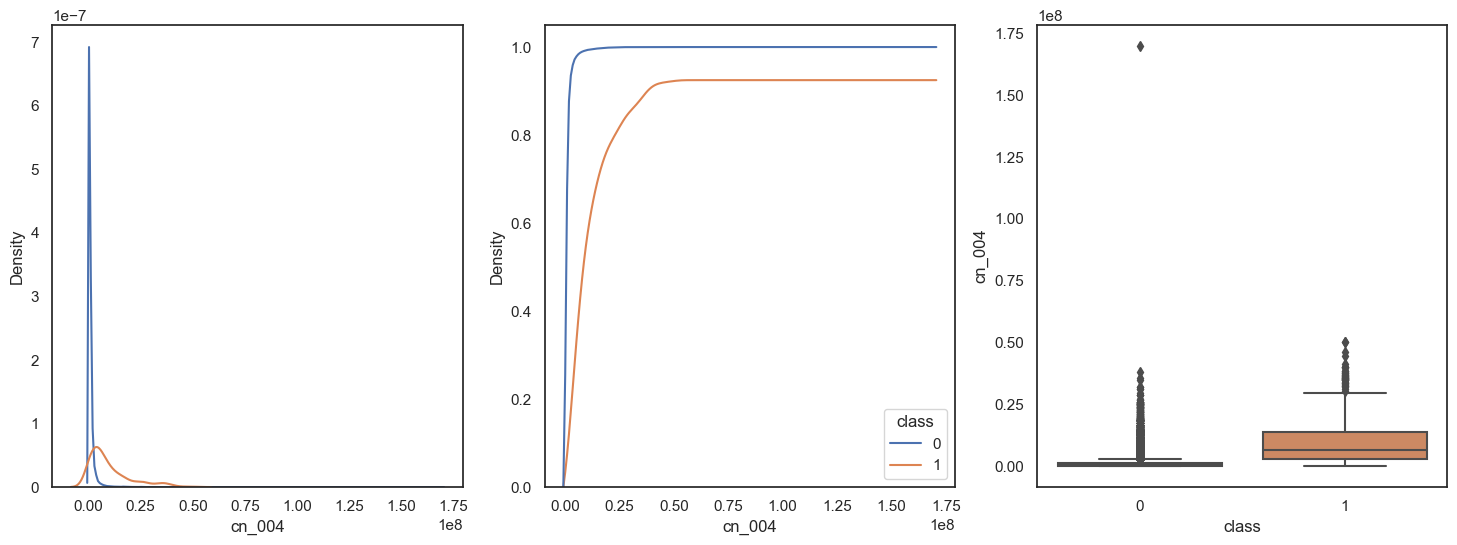

****************************************************************************************************
Feature 'cs_002' , Class Label 1, Mean: 2905755.64
Standard Deviation 3685371.14 

Feature 'cs_002' , Class Label 0, Mean: 126004.95
And Standard Deviation is 683806.88 


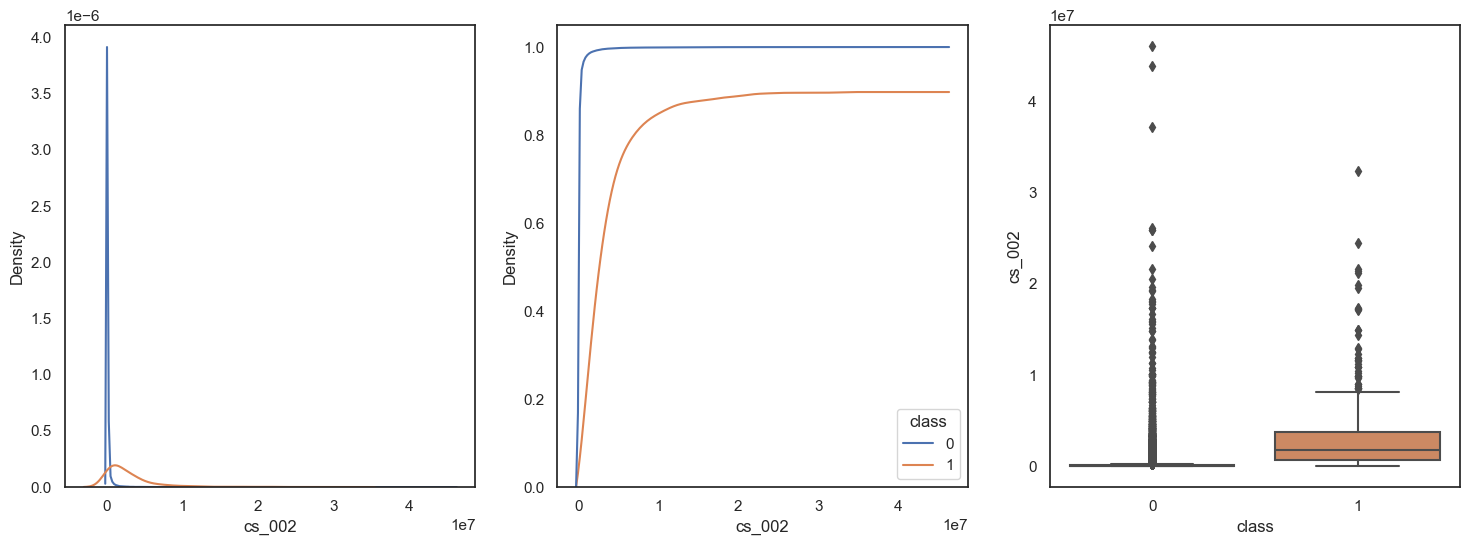

****************************************************************************************************
Feature 'cs_004' , Class Label 1, Mean: 5780159.69
Standard Deviation 8907309.94 

Feature 'cs_004' , Class Label 0, Mean: 241717.18
And Standard Deviation is 1026424.43 


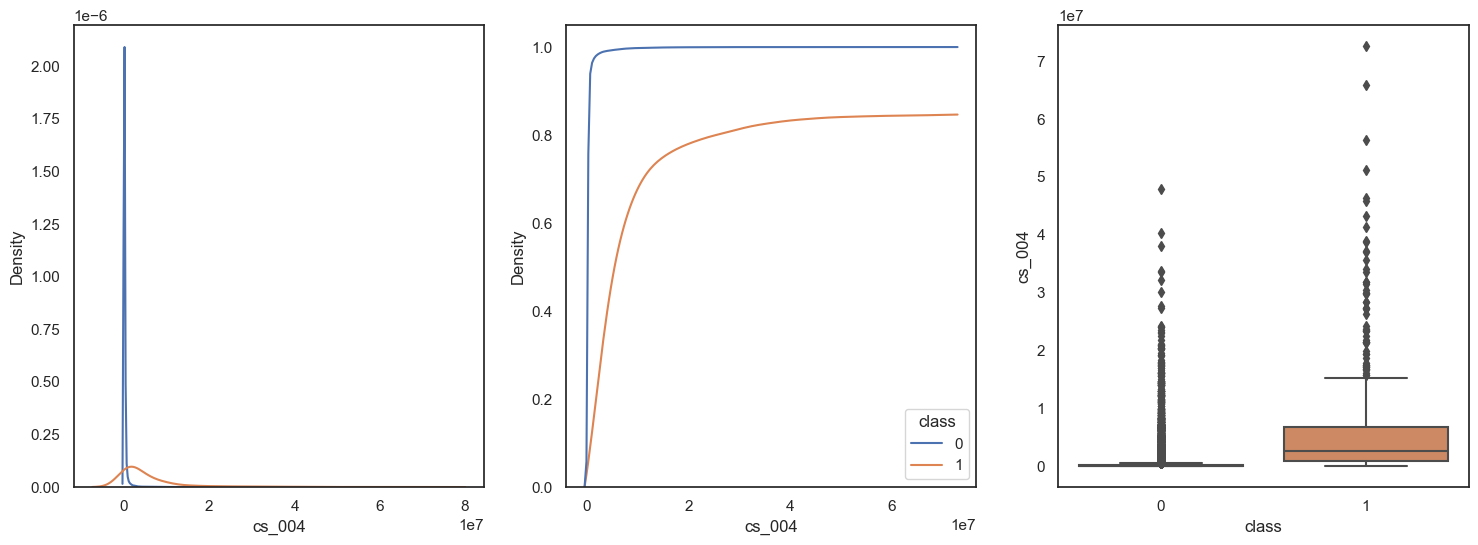

****************************************************************************************************
Feature 'ee_003' , Class Label 1, Mean: 1586282.44
Standard Deviation 1900148.65 

Feature 'ee_003' , Class Label 0, Mean: 159675.15
And Standard Deviation is 339293.25 


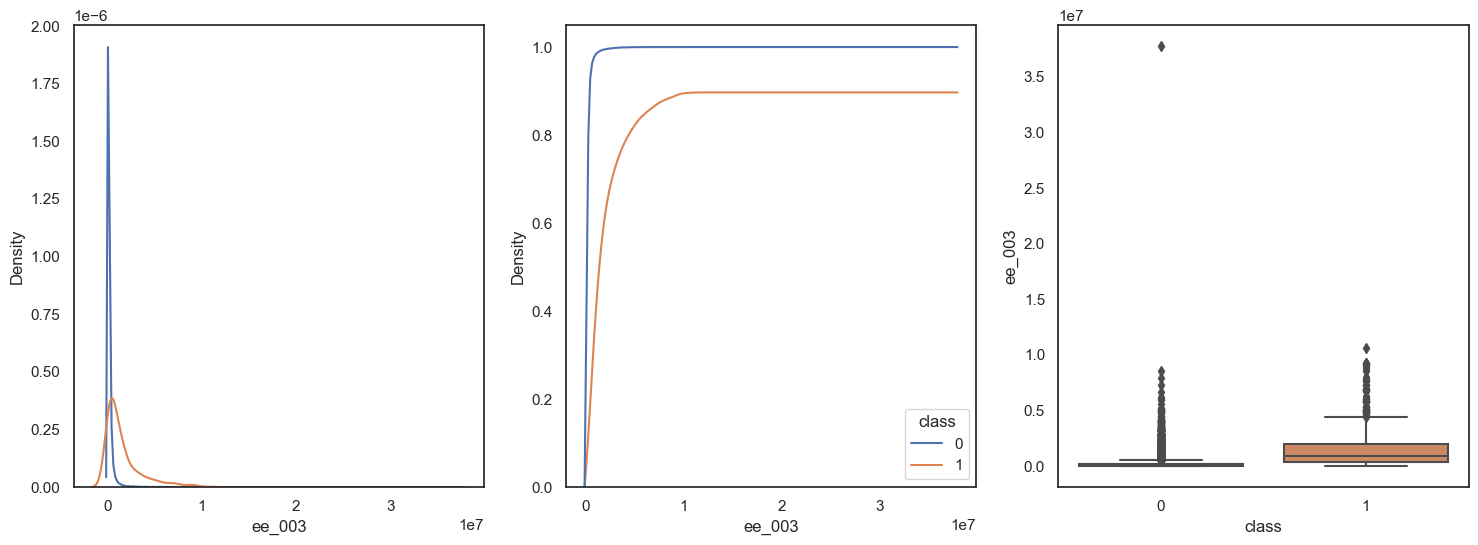

****************************************************************************************************
Feature 'ee_005' , Class Label 1, Mean: 3597279.1
Standard Deviation 4318345.11 

Feature 'ee_005' , Class Label 0, Mean: 286959.68
And Standard Deviation is 527650.47 


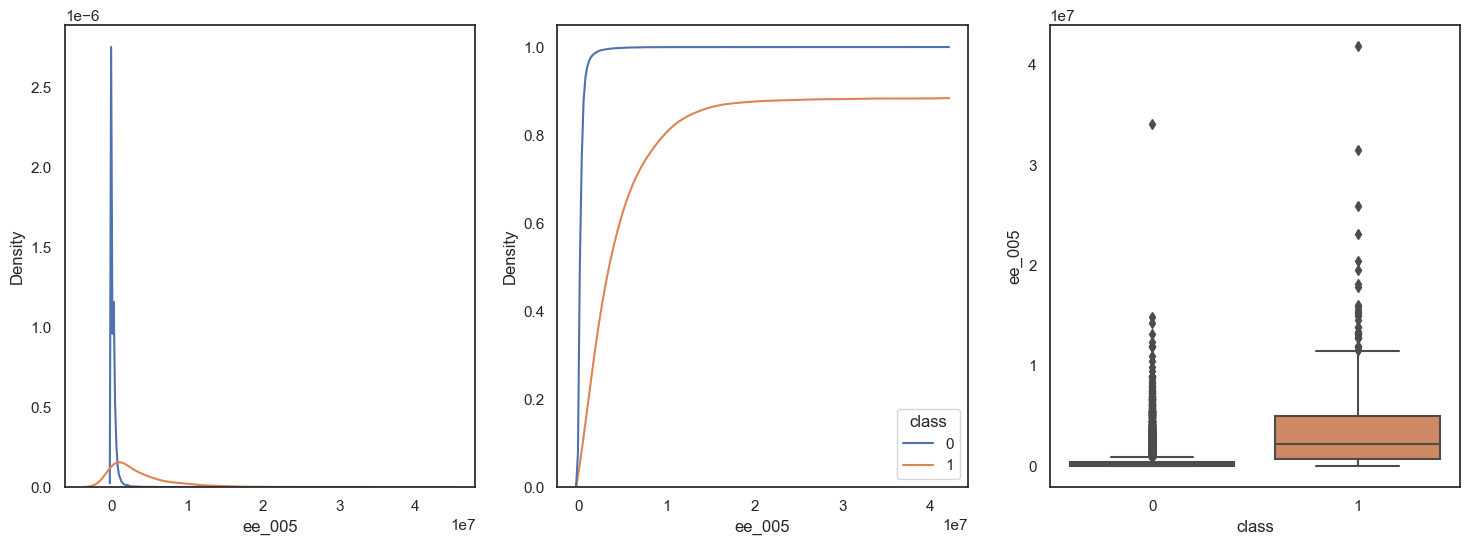

****************************************************************************************************


In [30]:
def plots(x):
  
    for n in x.columns.tolist():
        if n != 'class':

            describe_0 = x[x['class']==0].describe()
            describe_1 = x[x['class']==1].describe()

            fig,ax = plt.subplots(1,3,figsize=(18,6))
            
            print( '\033[1m' + "Feature '{}' , Class Label 1, Mean: {}".format(n , round(describe_1[n].iloc[1],2) ) )
            print( "Standard Deviation {} ".format( round(describe_1[n].iloc[2],2) ) )
            print( "\nFeature '{}' , Class Label 0, Mean: {}".format(n , round(describe_0[n].iloc[1],2) ) )
            print( "And Standard Deviation is {} ".format( round(describe_0[n].iloc[2],2) ) )
            
            sns.set_theme(style='white')
            # Plot PDF of points belonging to negative class
            sns.distplot(x[x['class']==0][n],ax=ax[0],hist=False)
            # Plot PDF of points belonging to positive class 
            sns.distplot(x[x['class']==1][n],ax=ax[0],hist=False)
            # Plot CDF of the feature values
            sns.kdeplot(data=x, x=x[n], hue="class",cumulative=True, common_norm=False, common_grid=True,ax=ax[1])
            # Plot the Box-Plot
            sns.boxplot(x=x['class'],y=x[n],ax=ax[2])
            plt.savefig('plot_{}.png'.format(n), dpi=300)
            plt.show()
            print('*'*100)

plots(top_features)

From the plot, we can observe that in features “ag_003, ba_002, ay_008, ba_003, cn_004, ba_004, cs_002, ee_003 and cs_004” there  are no APS failures, when the values are low and it exhibits APS failure when the values are high

But there are features such as "ay_005", where the values are higher than usual, but it does not result in a APS failure.

As a next step, we calculate the correlation between the features using the corr() function. 

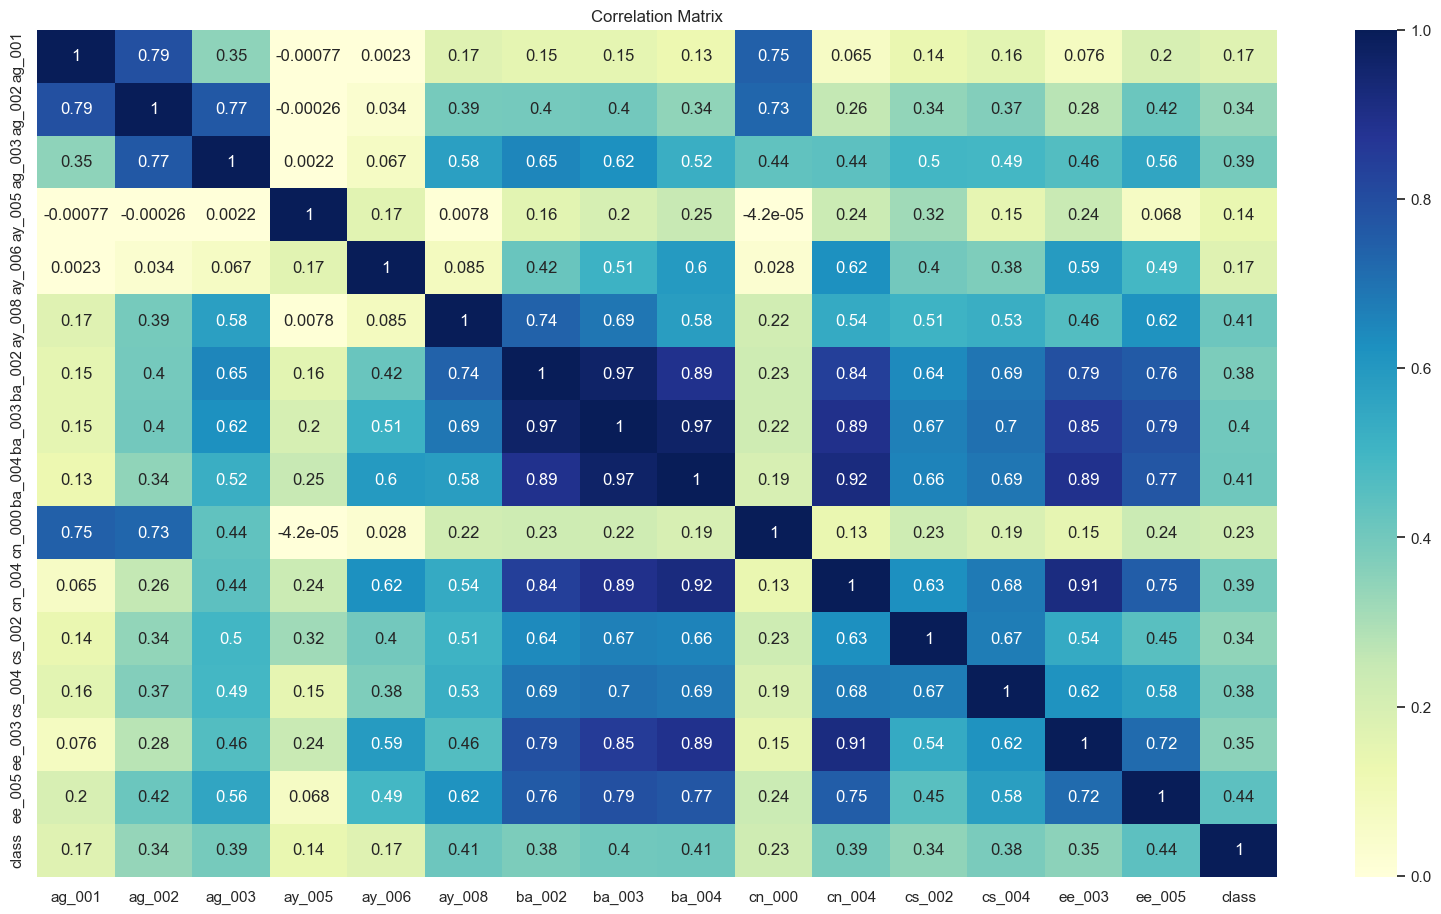

In [31]:
# Plot Correlation Heatmap      
plt.figure(figsize=(20,11))
sns.heatmap(top_features.corr(),cmap = 'YlGnBu', annot=True)
plt.title("Correlation Matrix")
plt.show()

From the plot, we can observe that “ba_002, ba_003 and ba_004” have a strong relationship between them, as they have a positive correlation coefficient close to 1 and feature "ay_005" is the most uncorrelated feature and has a weaker relationship with "ag_001, cn_000 and ag_002"

In [32]:
# Getting correlation coeffiecients of features w.r.t class
correlation_values = top_features.corr().loc['class']

# Get top 5 features
top_correlated_features = correlation_values.sort_values().iloc[:5].index.tolist()
print("Most Uncorrelated Feature is",top_correlated_features[0])

Most Uncorrelated Feature is ay_005


We conduct bivariate analysis on the negatively correlated features with respect to feature ay_005. We observe that whenver the value of ay_005 is close to zero, there are more chances of APS failure.

Variation of top features w.r.t feature ay_005


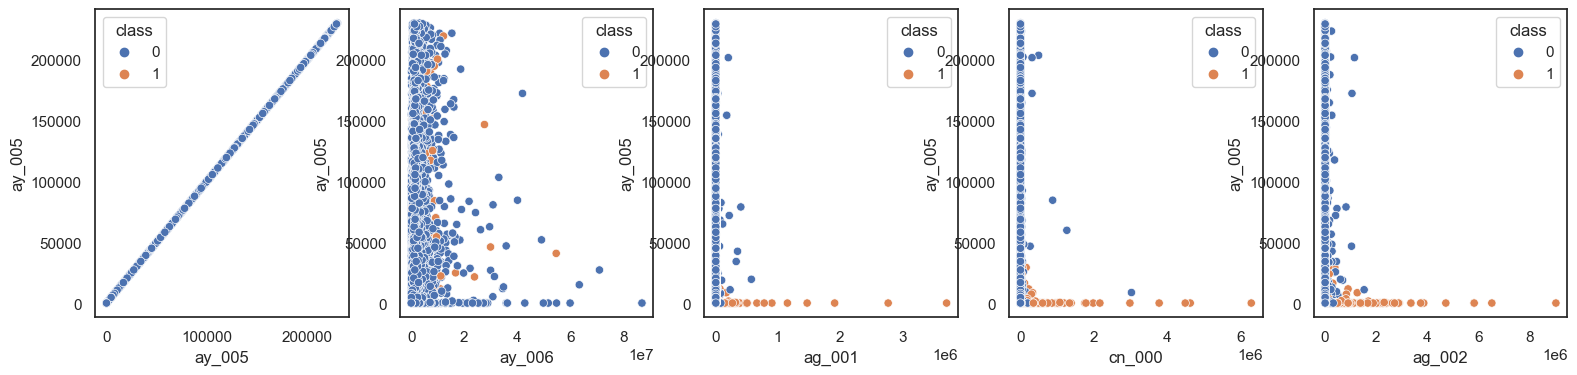

In [33]:
def plot_scatter(df,feature,percentile_value):
    """
    This function plots scatter plots between 
    all the features of the dataframe, w.r.t a given feature
    """
    fig,ax = plt.subplots(1,5,figsize=(19,4))

    # Only include the data consisting of values below the given percentile
    p = np.nanpercentile(df[feature],percentile_value)
    df = df[df[feature]<p]
    
    columns = df.columns.tolist()
    for i in range(len(columns)):
        if columns[i] !='class':
            # Plot scatterplot between 2 given features
            sns.scatterplot(x=df[columns[i]],y=df[feature],hue=df['class'],ax=ax[i])
    plt.show()


print('\033[1m'+"Variation of top features w.r.t feature",top_correlated_features[0])
plot_scatter(top_features[top_correlated_features + ['class']],top_correlated_features[0],95)


Using the same function we used for histogram feature selection, we select the top fifteen numerical data

In [34]:
top_feature_num = get_top(x_without_hist , y_train , 15)
print("The top features selected after Recursive Feature Elimination are: \n",top_feature_num)

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 fe

Creating dataframe with top fifteen features of numerical data obtained and conduct exploratory data analysis on the data with missing values

In [123]:
top_features = pd.DataFrame(data=x_train[top_feature_num],columns=top_feature_num)
top_features['class'] = y_train
top_features.head()

,al_000,am_0,ap_000,aq_000,bj_000,bu_000,bv_000,ci_000,cj_000,cq_000,dg_000,dn_000,do_000,dr_000,dx_000,class
0,0.0,0.0,1766008.0,1132040.0,799478.0,6700214.0,6700214.0,5245752.00,0.0,6700214.0,0.0,62282.0,85908.0,0.0,0.0,0
1,0.0,0.0,1084598.0,338544.0,392208.0,3646660.0,3646660.0,2291079.36,0.0,3646660.0,0.0,33736.0,36946.0,0.0,0.0,0
2,0.0,0.0,300796.0,153698.0,139730.0,2673338.0,2673338.0,2322692.16,0.0,2673338.0,0.0,13876.0,38182.0,0.0,0.0,0
3,642.0,3894.0,10764.0,1014.0,3090.0,21614.0,21614.0,2135.04,0.0,21614.0,0.0,232.0,0.0,370.0,20174.0,0
4,0.0,0.0,1058136.0,551022.0,399410.0,4289260.0,4289260.0,3565684.80,0.0,4289260.0,0.0,44946.0,62648.0,0.0,98334.0,0


Feature 'al_000' , Class Label 1, Mean: 1312909.33
Standard Deviation 2272430.58 

Feature 'al_000' , Class Label 0, Mean: 21663.77
And Standard Deviation is 225571.81 


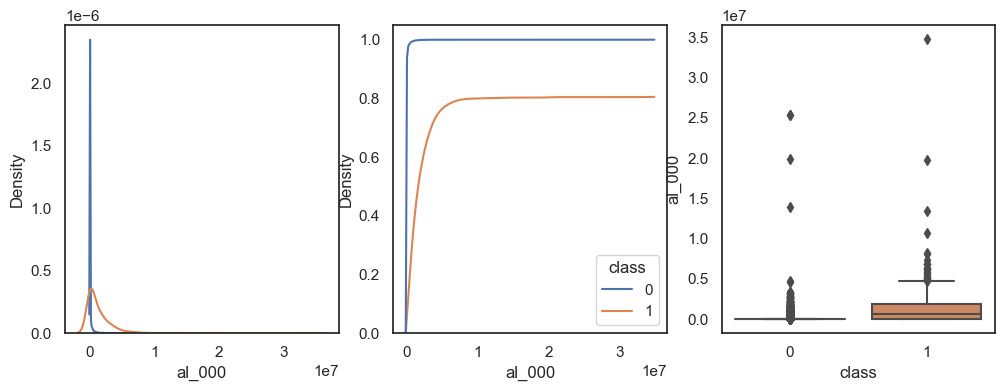

****************************************************************************************************
Feature 'am_0' , Class Label 1, Mean: 1994335.93
Standard Deviation 3270109.24 

Feature 'am_0' , Class Label 0, Mean: 32289.62
And Standard Deviation is 346731.24 


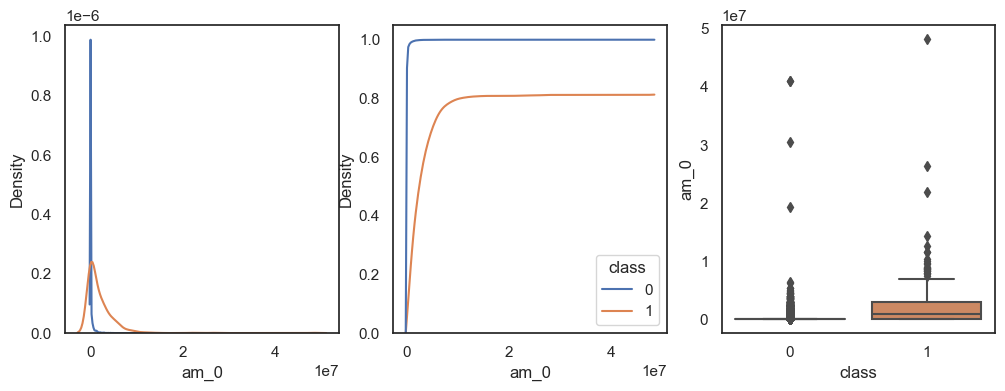

****************************************************************************************************
Feature 'ap_000' , Class Label 1, Mean: 10488936.15
Standard Deviation 8148251.03 

Feature 'ap_000' , Class Label 0, Mean: 644263.25
And Standard Deviation is 1652584.96 


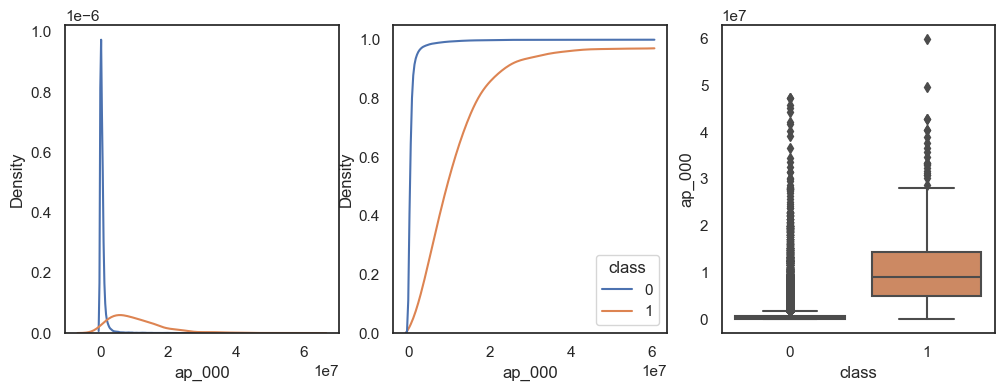

****************************************************************************************************
Feature 'aq_000' , Class Label 1, Mean: 4643078.91
Standard Deviation 3511008.41 

Feature 'aq_000' , Class Label 0, Mean: 302755.05
And Standard Deviation is 700480.39 


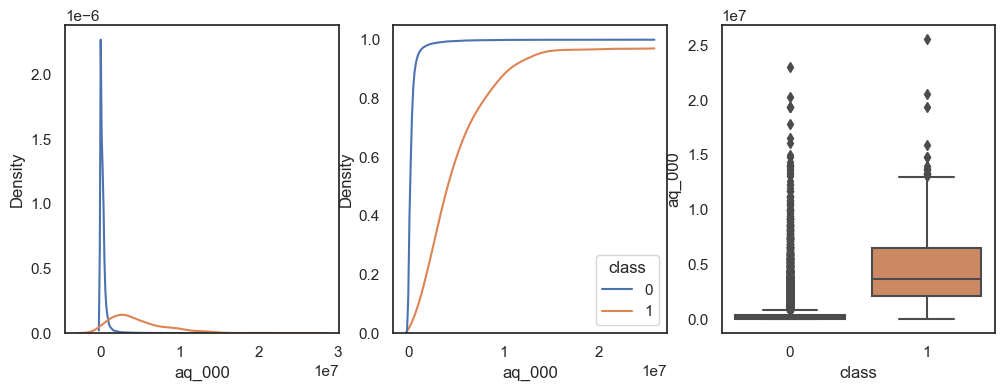

****************************************************************************************************
Feature 'bj_000' , Class Label 1, Mean: 5831411.41
Standard Deviation 4576782.56 

Feature 'bj_000' , Class Label 0, Mean: 299729.99
And Standard Deviation is 830798.42 


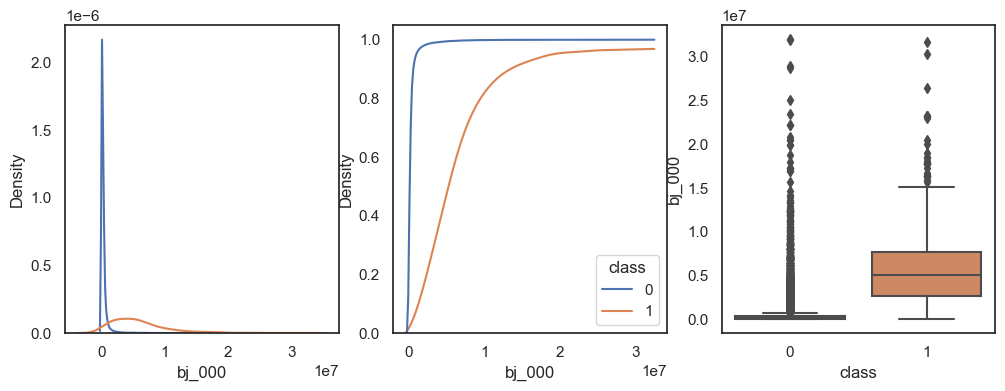

****************************************************************************************************
Feature 'bu_000' , Class Label 1, Mean: 42802828.22
Standard Deviation 27014980.92 

Feature 'bu_000' , Class Label 0, Mean: 3241405.56
And Standard Deviation is 6523062.7 


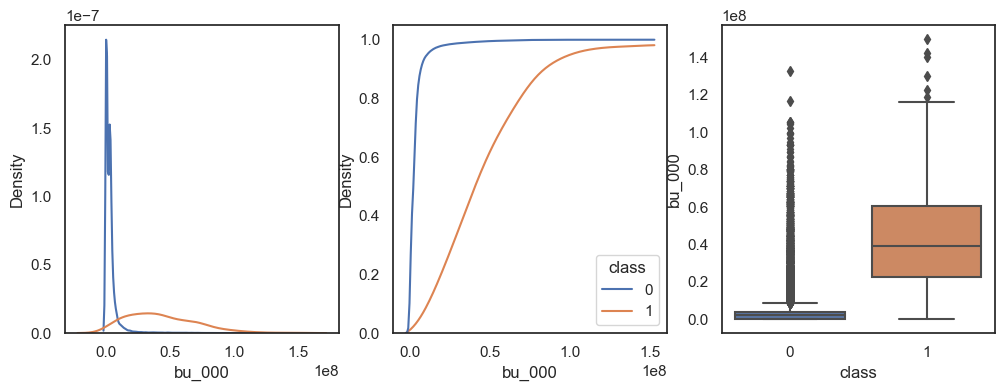

****************************************************************************************************
Feature 'bv_000' , Class Label 1, Mean: 42802836.54
Standard Deviation 27014984.75 

Feature 'bv_000' , Class Label 0, Mean: 3241405.95
And Standard Deviation is 6523063.28 


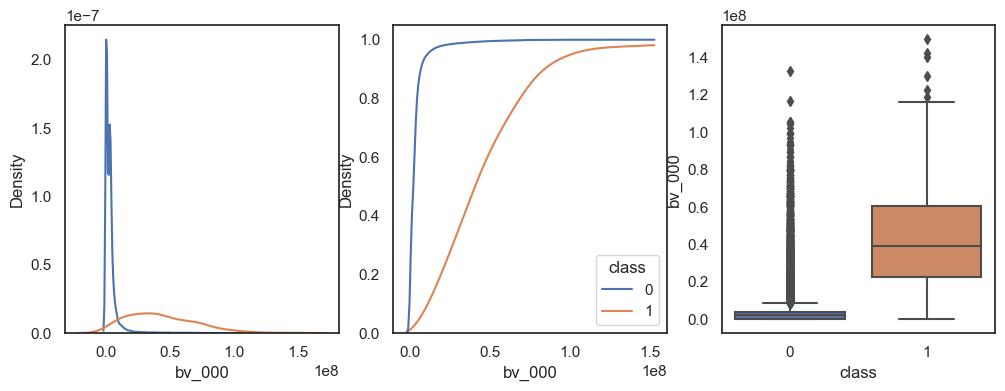

****************************************************************************************************
Feature 'ci_000' , Class Label 1, Mean: 31381992.22
Standard Deviation 20155474.63 

Feature 'ci_000' , Class Label 0, Mean: 2468026.5
And Standard Deviation is 4870368.19 


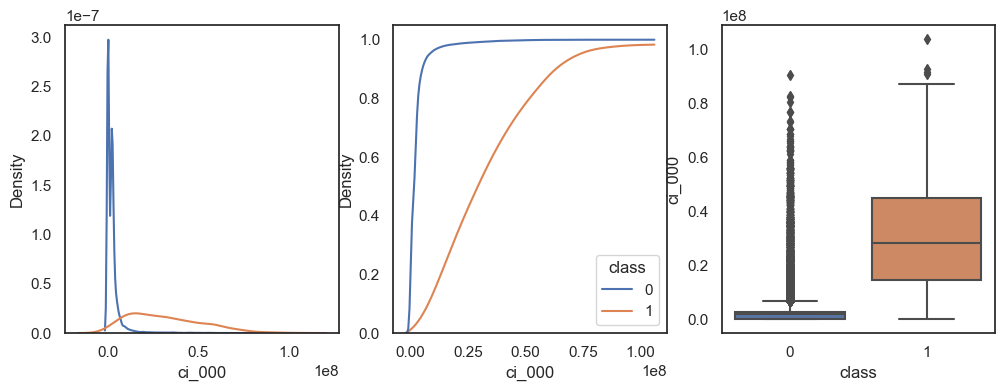

****************************************************************************************************
Feature 'cj_000' , Class Label 1, Mean: 2532895.71
Standard Deviation 5390620.1 

Feature 'cj_000' , Class Label 0, Mean: 39023.21
And Standard Deviation is 425739.22 


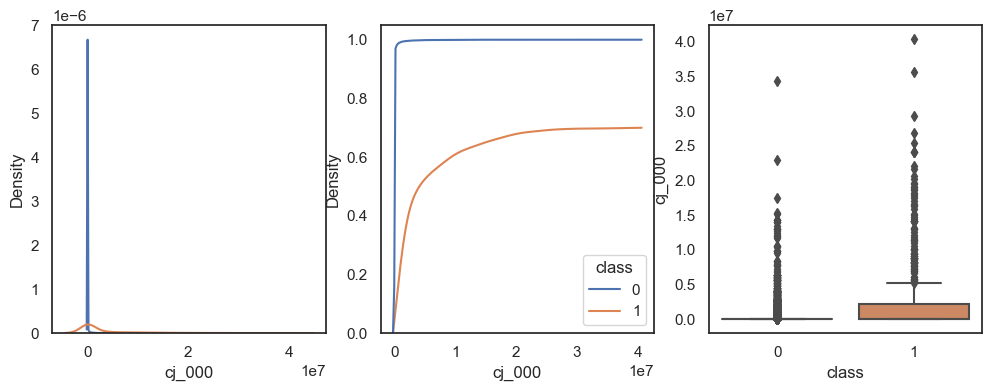

****************************************************************************************************
Feature 'cq_000' , Class Label 1, Mean: 42802828.39
Standard Deviation 27014981.02 

Feature 'cq_000' , Class Label 0, Mean: 3241405.93
And Standard Deviation is 6523063.27 


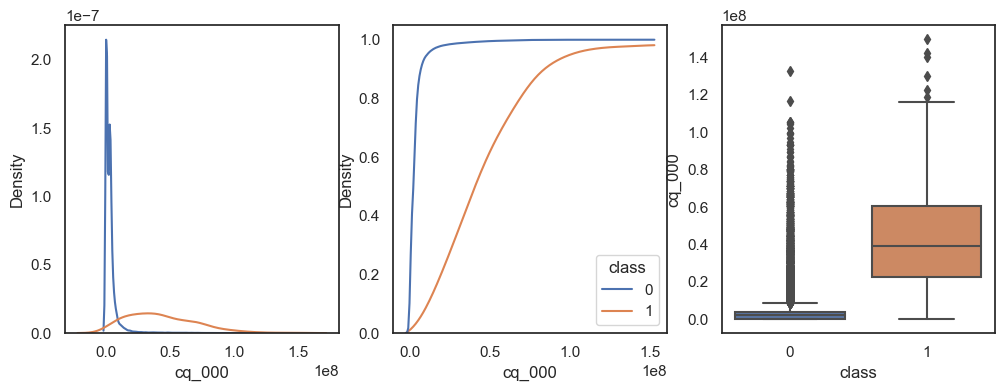

****************************************************************************************************
Feature 'dg_000' , Class Label 1, Mean: 380774.0
Standard Deviation 1590126.18 

Feature 'dg_000' , Class Label 0, Mean: 1868.74
And Standard Deviation is 91825.18 


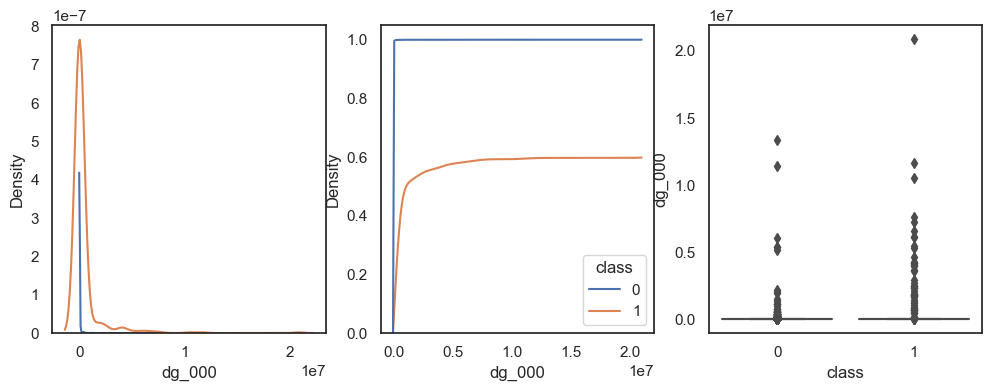

****************************************************************************************************
Feature 'dn_000' , Class Label 1, Mean: 353815.14
Standard Deviation 258573.93 

Feature 'dn_000' , Class Label 0, Mean: 23673.72
And Standard Deviation is 61790.16 


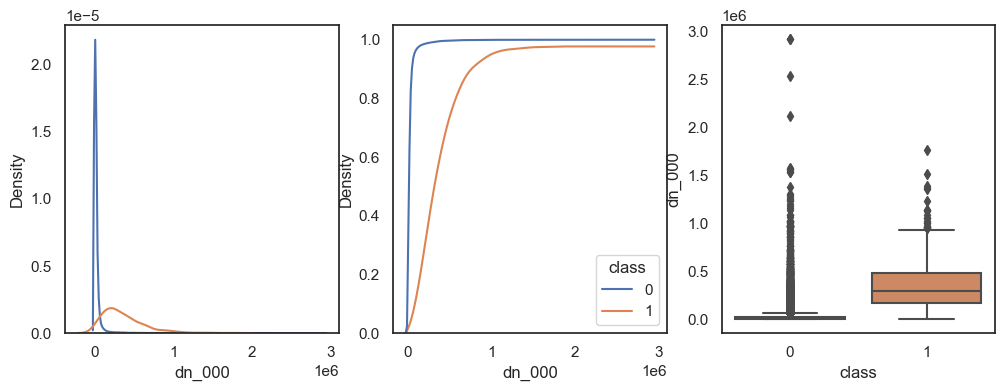

****************************************************************************************************
Feature 'do_000' , Class Label 1, Mean: 237157.12
Standard Deviation 311932.98 

Feature 'do_000' , Class Label 0, Mean: 26568.72
And Standard Deviation is 47842.76 


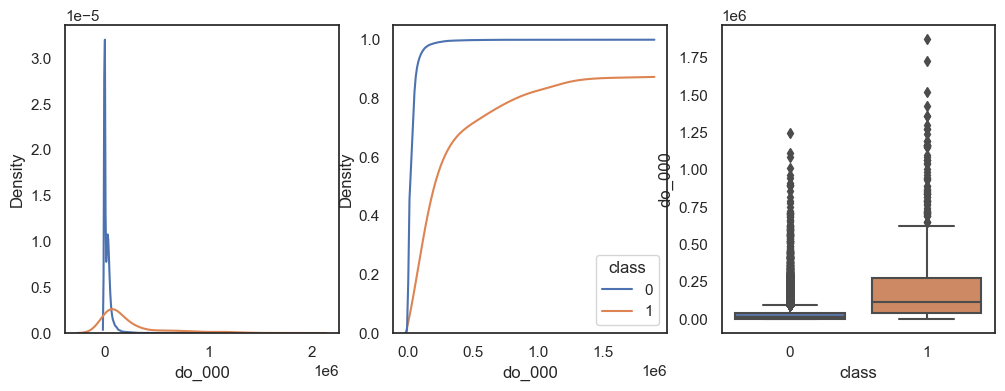

****************************************************************************************************
Feature 'dr_000' , Class Label 1, Mean: 2810612.1
Standard Deviation 5959831.87 

Feature 'dr_000' , Class Label 0, Mean: 175866.6
And Standard Deviation is 1201880.44 


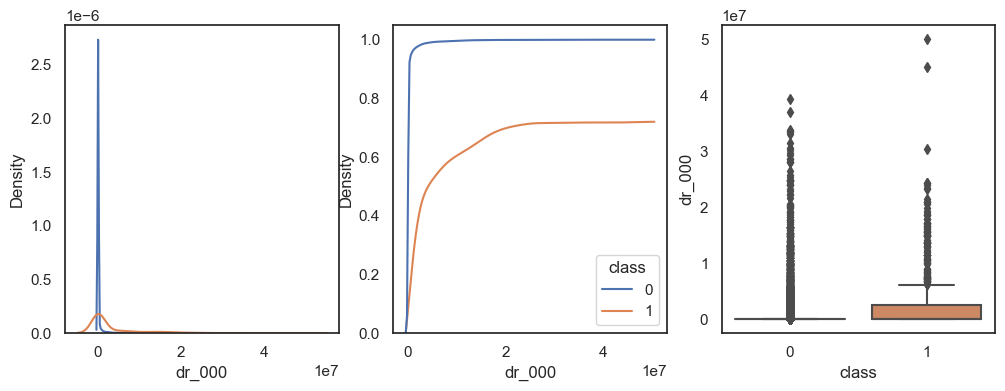

****************************************************************************************************
Feature 'dx_000' , Class Label 1, Mean: 8321052.93
Standard Deviation 16477013.07 

Feature 'dx_000' , Class Label 0, Mean: 714172.87
And Standard Deviation is 3754542.97 


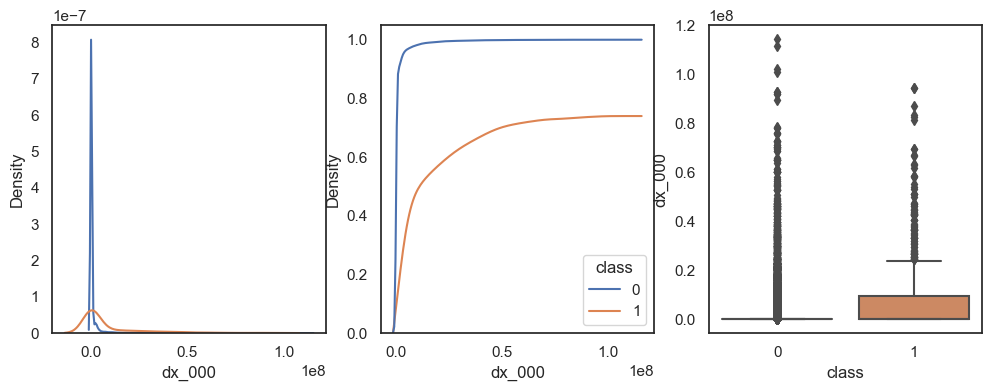

****************************************************************************************************


In [124]:
plots(top_features)

From the plots,we can interpret that feature 'ap_000',in both the instances class 0 and 1 overlap each other, which means the probability of both APS ans non APS failure are almost same and very high. There are some instances in which values are higher than expected but did not result in an APS failure.  Also, the data points of the class 1 variable are widely spread when compared to class 0. This is the same case with features “aq_000, bj_000, bu_000” where a high value indicates a failure of an APS component.

In feature "am_o", the failures are not seperable as in both cases the high values indicate as APS failure. Features "dg 000, cj 000, and al 000" exhibit the same characteristics

Features ‘dn_000’and ‘dx_000’ are the two cases where a very high value causes failure in non-APS system rather than causing failure in a APS system which was the case in all other features.



As a next step, we calculate the correlation between the features to identify which the most correlated feature and which one is the most uncorrelated feature. 

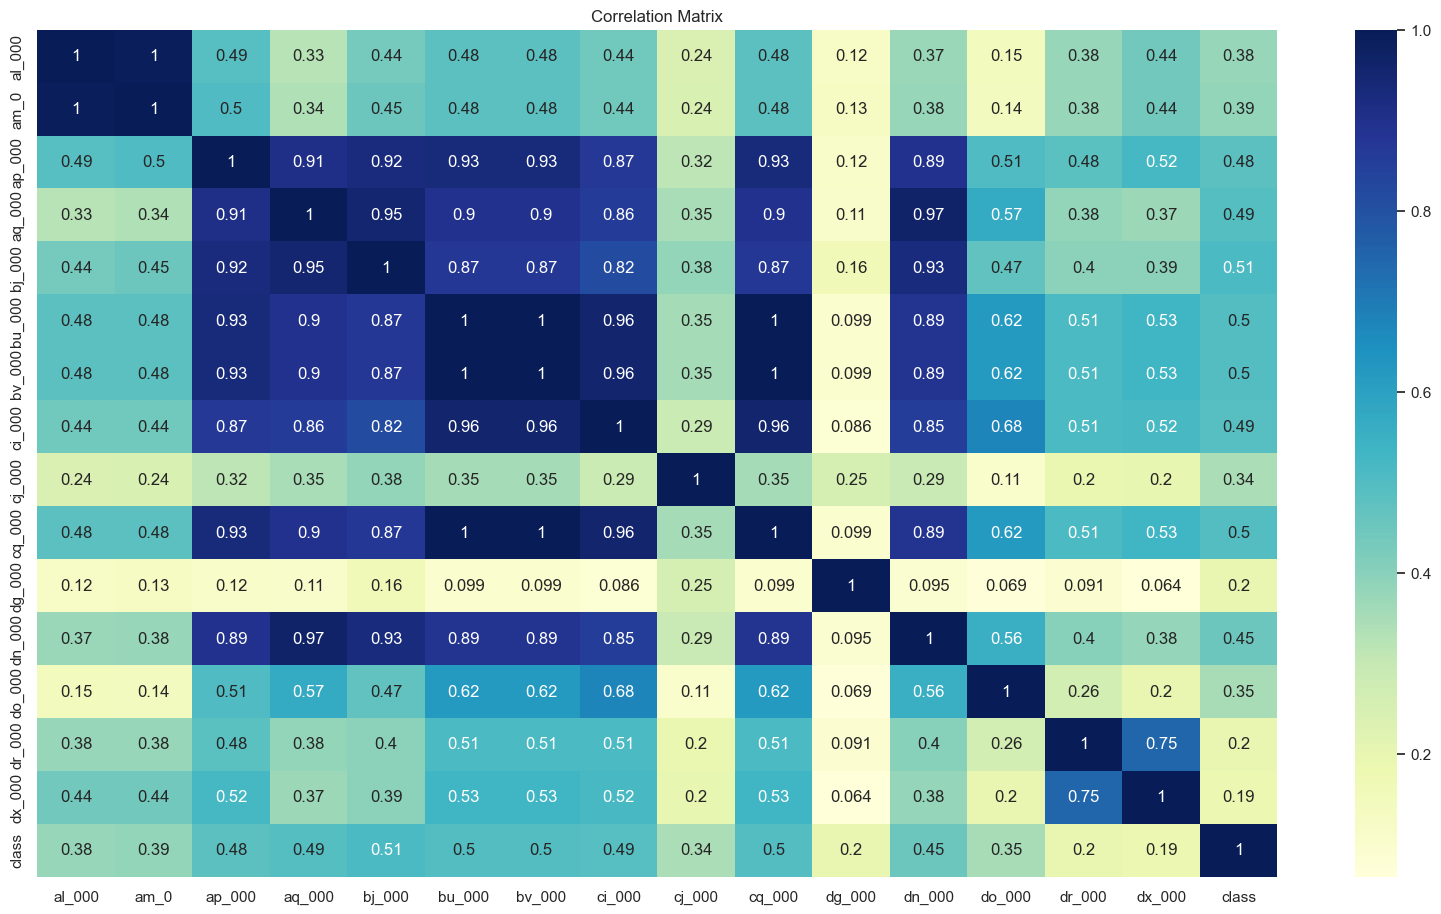

In [125]:
plt.figure(figsize=(20,11))
sns.heatmap(top_features.corr(),cmap = 'YlGnBu', annot=True)
plt.title("Correlation Matrix")
plt.show()

From the plot, we can see that "dx_000" is the most uncorrelated feature as it has weaker relationships with other variables. Features "dn_000", "ap_000", "aq_000" have strong relationship between them

In [126]:
correlation_values = top_features.corr().loc['class']
correlation_values

top_correlated_features = correlation_values.sort_values().iloc[:5].index.tolist()
print("Most Uncorrelated Feature is",top_correlated_features[0])

Most Uncorrelated Feature is dx_000


We conduct bivariate analysis on feature dx_000 with respect other least correlated features, using the function we created earlier for the histogram features

Variation of top features w.r.t feature dx_000


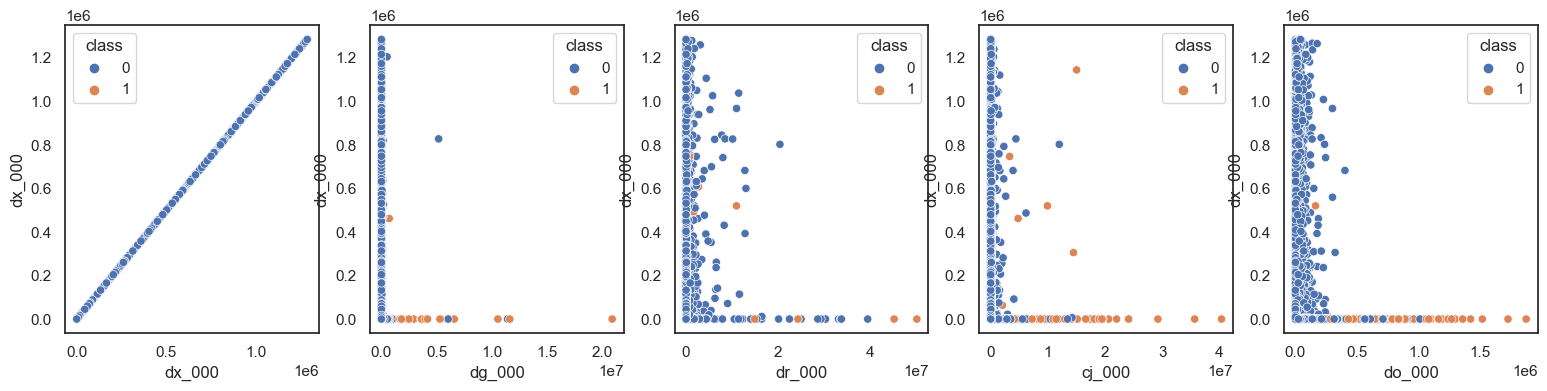

In [127]:
print('\033[1m'+"Variation of top features w.r.t feature",top_correlated_features[0])

plot_scatter(top_features[top_correlated_features + ['class']],top_correlated_features[0],90)

We can observe that, whenever the values of dx_000 is close to zero, there are high chances of failure in APS system

### Scaling and standardising the data

we scale the data using the MinMaxScaler() function from sklearn, so that all datapoints have the equal magnitued ranging  from 0 to 1.

In [26]:
def scale_data(df):
   
    min_max = MinMaxScaler()
    df = pd.DataFrame( data = min_max.fit_transform(df) , columns = df.columns )
    return df , min_max

To deal with the class imbalance, we use a combination of over sampling and under sampling technique. We make use of SMOTE and RandomUnderSampler function from 'imblearn package'

In [27]:
print("Scikit-learn version:", sklearn.__version__)
print("Imbalanced-learn version:", imblearn.__version__)

Scikit-learn version: 1.4.0
Imbalanced-learn version: 0.11.0


In [28]:
!pip install --upgrade scikit-learn imbalanced-learn
!pip install --upgrade threadpoolctl
seed(5)
def balance_data(df,label):
   
    over = SMOTE(random_state=42)
#     under = RandomUnderSampler(sampling_strategy=0.5)
#     steps = [('o', over), ('u', under)]
#     pipeline = Pipeline(steps=steps)
    df, label = over.fit_resample(df, label)
    return df, label

x_train , y_train = balance_data(imputed_x_train, y_train)
print(x_train.shape)
print(y_train.value_counts())

(110754, 162)
0    55377
1    55377
Name: class, dtype: int64


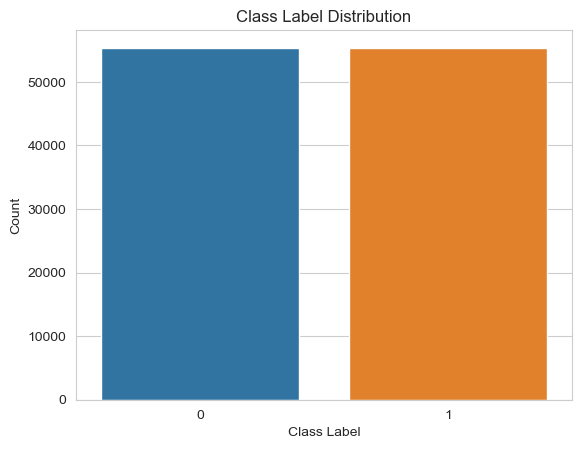

In [29]:
sns.barplot(y_train.unique(), y_train.value_counts())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

From the plot, we can observe that the imbalance has reduced. Previously the number of class 1 instances were very low. It was around 1,000. Now the number of class 1 instances are 15,000

In [30]:
x_train,scaler = scale_data(x_train)
x_test = pd.DataFrame(data = scaler.transform(x_test) , columns = x_test.columns)
print(x_train.shape,x_test.shape)

(110754, 162) (16000, 162)


We split the train data into train and validation data to test the data while training the model. we make use of `train_test_split` function from sklearn package

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
seed(5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(99678, 162)
(99678,)
(11076, 162)
(11076,)


### Installing tensor flow and necessary libraries

In [33]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [34]:
# Required libraries
import numpy as np  # Import NumPy for numerical operations
import tensorflow as tf  # Import TensorFlow for deep learning
from sklearn.datasets import make_moons  # Import make_moons dataset from scikit-learn
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting the dataset
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
from tensorflow.keras.models import Sequential  # Import Sequential model from Keras for creating a neural network
from tensorflow.keras.layers import Dense  # Import Dense layer for creating fully connected layers
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer for model optimization
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping for early stopping during training
from tensorflow.keras import regularizers  # Import regularizers for regularization techniques
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC

### MODEL BUILDING AND EVALUATION 

# Test Model 1 : Sequential model using Keras

In [35]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras import regularizers
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Create a Sequential model
model = Sequential([
    Dense(128, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l1(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy, recall, AUC-ROC metrics
model.compile(optimizer=Adam(lr=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), AUC()])

# Set up EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

# Train the model with the callback
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])


Epoch 1/10



2492/2492 [==============================] - 7s 2ms/step - loss: 0.3559 - accuracy: 0.9432 - recall: 0.9282 - auc: 0.9765 - val_loss: 0.2251 - val_accuracy: 0.9523 - val_recall: 0.9472 - val_auc: 0.9830
Epoch 2/10
2492/2492 [==============================] - 6s 2ms/step - loss: 0.2134 - accuracy: 0.9516 - recall: 0.9433 - auc: 0.9830 - val_loss: 0.2003 - val_accuracy: 0.9551 - val_recall: 0.9490 - val_auc: 0.9852
Epoch 3/10
2492/2492 [==============================] - 6s 2ms/step - loss: 0.1940 - accuracy: 0.9539 - recall: 0.9457 - auc: 0.9850 - val_loss: 0.1852 - val_accuracy: 0.9576 - val_recall: 0.9548 - val_auc: 0.9864
Epoch 4/10
2492/2492 [==============================] - 6s 2ms/step - loss: 0.1818 - accuracy: 0.9565 - recall: 0.9490 - auc: 0.9864 - val_loss: 0.1735 - val_accuracy: 0.9607 - val_recall: 0.9569 - val_auc: 0.9880
Epoch 5/10
2492/2492 [==============================] - 6s 2ms/step - loss: 0.1731 - accuracy: 0.9584 - recall: 0.9514 - auc: 0.9874 - val_loss: 0.1720 - v

In [36]:
# Print the keys of history.history
print("Available Metrics in Training History:", history.history.keys())

Available Metrics in Training History: dict_keys(['loss', 'accuracy', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_auc'])


Final Training Results:
Loss: 0.1577
Accuracy: 96.16%
Recall: 95.57%
AUC-ROC: 98.95%

Final Validation Results:
Loss: 0.1630
Accuracy: 96.29%
Recall: 97.13%
AUC-ROC: 99.06%


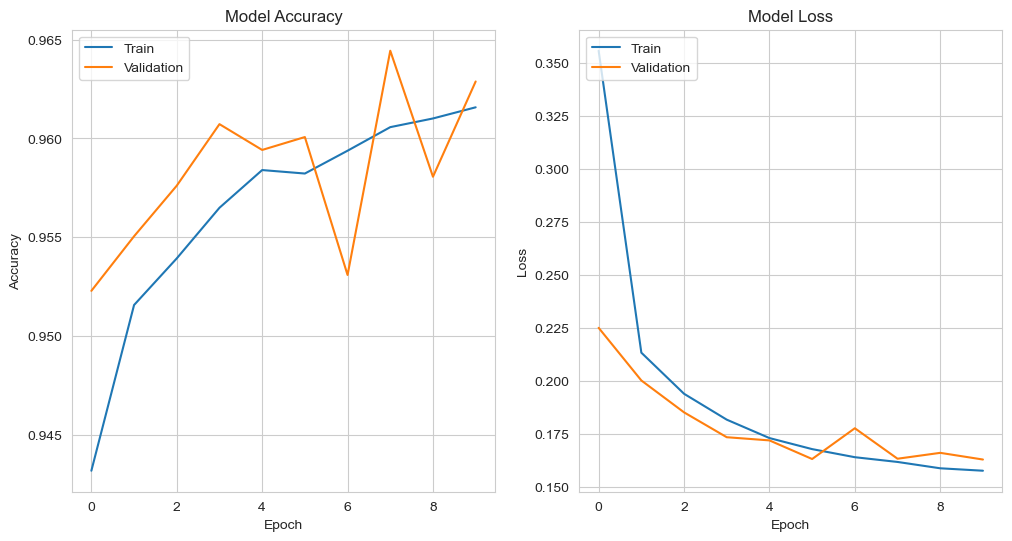

Available Metrics in Training History: ['loss', 'accuracy', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_auc']


In [37]:
import matplotlib.pyplot as plt

# Extract final values for training
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
final_train_recall = history.history['recall'][-1] * 100  # Convert to percentage
final_train_auc = history.history['auc'][-1] * 100  # Convert to percentage

# Extract final values for validation
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
final_val_recall = history.history['val_recall'][-1] * 100  # Convert to percentage
final_val_auc = history.history['val_auc'][-1] * 100  # Convert to percentage

# Print the final training results
print("Final Training Results:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_accuracy:.2f}%")
print(f"Recall: {final_train_recall:.2f}%")
print(f"AUC-ROC: {final_train_auc:.2f}%")

# Print the final validation results
print("\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_accuracy:.2f}%")
print(f"Recall: {final_val_recall:.2f}%")
print(f"AUC-ROC: {final_val_auc:.2f}%")

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Print the keys of history.history
print("Available Metrics in Training History:", list(history.history.keys()))

In [38]:
import tensorflow as tf

# Evaluate the model on test data, if available
if 'x_test' in locals() and 'y_test' in locals():
    test_results = model.evaluate(x_test, y_test)
    test_loss = test_results[0]  # Get the test loss (assuming it's the first element)
    print("\nTest Results:")
    print(f"Loss: {test_loss:.4f}")

    # Predict using the model
    y_pred = model.predict(x_test)

    # Initialize TensorFlow metrics
    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    recall_metric = tf.keras.metrics.Recall()
    auc_metric = tf.keras.metrics.AUC()

    # Update the states of the metrics
    accuracy_metric.update_state(y_test, y_pred)
    recall_metric.update_state(y_test, y_pred)
    auc_metric.update_state(y_test, y_pred)

    # Calculate and print the results
    test_accuracy = accuracy_metric.result().numpy()
    test_recall = recall_metric.result().numpy()
    test_auc = auc_metric.result().numpy()

    print(f"Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Recall: {test_recall * 100:.2f}%")
    print(f"AUC-ROC: {test_auc * 100:.2f}%")
else:
    print("Test data not available.")


500/500 [==============================] - 1s 2ms/step - loss: 0.3748 - accuracy: 0.9380 - recall: 0.9760 - auc: 0.9832

Test Results:
Loss: 0.3748
500/500 [==============================] - 1s 1ms/step
Accuracy: 93.80%
Recall: 97.60%
AUC-ROC: 98.32%


In [85]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load your dataset
test_data_df = pd.read_csv("aps_failure_test_set.csv", skiprows=20, na_values=["na"])

# Separate features and labels if labels are included in the dataset
# This is assuming that the last column is the label
X_test = test_data_df.iloc[:, :-1]  # all rows, all columns except the last
y_test = test_data_df.iloc[:, -1]   # all rows, only the last column

# Convert categorical labels to numbers if necessary (e.g., 'neg' to 0 and 'pos' to 1)
# You would only do this if you are also evaluating the model's performance
label_mapping = {'neg': 0, 'pos': 1}
y_test = y_test.map(label_mapping)

# Handle missing values. Here we'll use median imputation as an example
X_test = X_test.fillna(X_test.median())

# Convert all features to float32
X_test = X_test.astype('float32')

# Load the model
loaded_model = load_model('path/to/your/saved/model.h5')

# Make sure the input data shape matches the model's expectation
# For example, if your model expects a certain number of features:
if X_test.shape[1] != model.input_shape[1]:
    raise ValueError(f"Model expects {model.input_shape[1]} features, but test data has {X_test.shape[1]} features.")

# Predict using the model
predictions = loaded_model.predict(X_test)

# Rest of your code...


ValueError: could not convert string to float: 'neg'

# Test Model 2 : Sequential Keras Adjusting Hyperparameters

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Recall, AUC

# Assume x_train, y_train are already defined and preprocessed

# Create a Sequential model using Keras
model = Sequential([
    Dense(256, activation='tanh', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l1(0.005)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.005)),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with Adam optimizer, binary crossentropy loss, and include accuracy, recall, and AUC metrics
model.compile(optimizer=Adam(lr=0.005), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), AUC()])

# Set up EarlyStopping callback to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

# Train the model on the training data with validation split and EarlyStopping callback
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.3, callbacks=[callback])


Epoch 1/15
1091/1091 [==============================] - 5s 4ms/step - loss: 1.5482 - accuracy: 0.9280 - recall_2: 0.8935 - auc_2: 0.9649 - val_loss: 0.3744 - val_accuracy: 0.9343 - val_recall_2: 0.9131 - val_auc_2: 0.9734
Epoch 2/15
1091/1091 [==============================] - 4s 3ms/step - loss: 0.3362 - accuracy: 0.9420 - recall_2: 0.9239 - auc_2: 0.9759 - val_loss: 0.3136 - val_accuracy: 0.9452 - val_recall_2: 0.9361 - val_auc_2: 0.9782
Epoch 3/15
1091/1091 [==============================] - 4s 3ms/step - loss: 0.3028 - accuracy: 0.9451 - recall_2: 0.9313 - auc_2: 0.9790 - val_loss: 0.2972 - val_accuracy: 0.9442 - val_recall_2: 0.9274 - val_auc_2: 0.9790
Epoch 4/15
1091/1091 [==============================] - 4s 3ms/step - loss: 0.2893 - accuracy: 0.9466 - recall_2: 0.9340 - auc_2: 0.9799 - val_loss: 0.2925 - val_accuracy: 0.9487 - val_recall_2: 0.9492 - val_auc_2: 0.9801
Epoch 5/15
1091/1091 [==============================] - 4s 3ms/step - loss: 0.2789 - accuracy: 0.9480 - recall_2

In [47]:
# Print the keys of history.history
print("Available Metrics in Training History:", history.history.keys())

Available Metrics in Training History: dict_keys(['loss', 'accuracy', 'recall_2', 'auc_2', 'val_loss', 'val_accuracy', 'val_recall_2', 'val_auc_2'])


Final Training Results:
Loss: 0.2536
Accuracy: 94.93%
Recall: 94.12%
AUC-ROC: 98.26%

Final Validation Results:
Loss: 0.2554
Accuracy: 94.89%
Recall: 94.41%
AUC-ROC: 98.30%


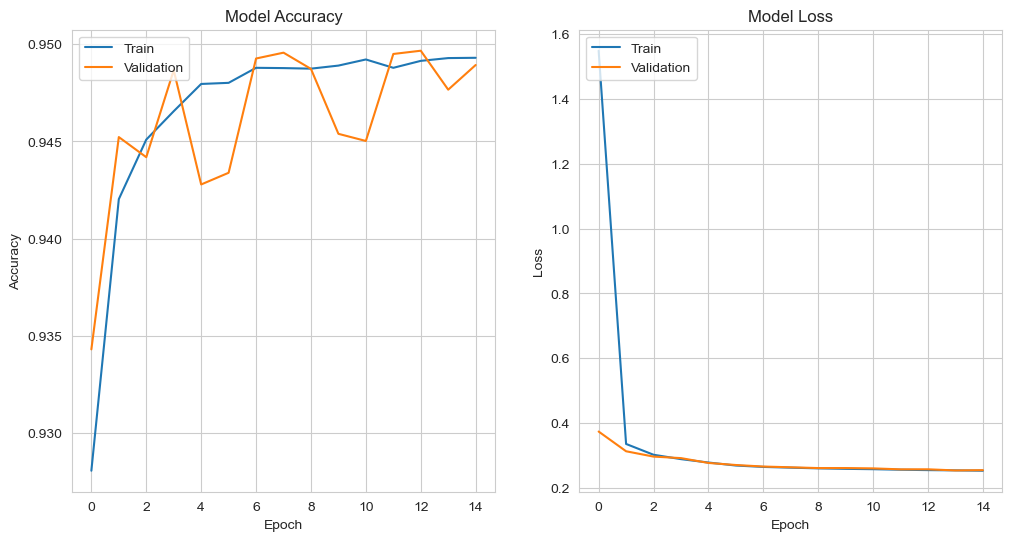

In [49]:
import matplotlib.pyplot as plt

# Extract final values for training
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
final_train_recall = history.history['recall_2'][-1] * 100  # Convert to percentage
final_train_auc = history.history['auc_2'][-1] * 100  # Convert to percentage

# Extract final values for validation
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
final_val_recall = history.history['val_recall_2'][-1] * 100  # Convert to percentage
final_val_auc = history.history['val_auc_2'][-1] * 100  # Convert to percentage

# Print the final training results
print("Final Training Results:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_accuracy:.2f}%")
print(f"Recall: {final_train_recall:.2f}%")
print(f"AUC-ROC: {final_train_auc:.2f}%")

# Print the final validation results
print("\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_accuracy:.2f}%")
print(f"Recall: {final_val_recall:.2f}%")
print(f"AUC-ROC: {final_val_auc:.2f}%")

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [50]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_recall, test_auc = model.evaluate(x_test, y_test, verbose=0)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')
print(f'Test AUC: {test_auc * 100:.2f}%')


Test Loss: 0.3080962896347046
Test Accuracy: 94.14%
Test Recall: 96.53%
Test AUC: 98.02%


### CNN  1D Convolutional Neural Network : Model 3 

In [51]:
pip install --upgrade tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import Recall, AUC


# Reshape input for CNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

from keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()

# Add 1D convolutional layer with ReLU activation
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(162, 1)))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer and max pooling layer
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Add fully connected layers with ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Add output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer, binary crossentropy loss, and additional metrics
model.compile(optimizer=Adam(lr=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), AUC()])


# Train the model on the training data
history= model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
#test_loss_and_metrics = model.evaluate(x_test, y_test)
#test_loss = test_loss_and_metrics[0]
#test_accuracy = test_loss_and_metrics[1]

#print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
2492/2492 [==============================] - 23s 9ms/step - loss: 0.1235 - accuracy: 0.9595 - recall_4: 0.9555 - auc_4: 0.9891 - val_loss: 0.0763 - val_accuracy: 0.9751 - val_recall_4: 0.9748 - val_auc_4: 0.9957
Epoch 2/10
2492/2492 [==============================] - 24s 10ms/step - loss: 0.0708 - accuracy: 0.9763 - recall_4: 0.9737 - auc_4: 0.9960 - val_loss: 0.0658 - val_accuracy: 0.9791 - val_recall_4: 0.9842 - val_auc_4: 0.9967
Epoch 3/10
2492/2492 [==============================] - 23s 9ms/step - loss: 0.0539 - accuracy: 0.9825 - recall_4: 0.9796 - auc_4: 0.9975 - val_loss: 0.0469 - val_accuracy: 0.9850 - val_recall_4: 0.9833 - val_auc_4: 0.9980
Epoch 4/10
2492/2492 [==============================] - 21s 9ms/step - loss: 0.0433 - accuracy: 0.9855 - recall_4: 0.9833 - auc_4: 0.9983 - val_loss: 0.0351 - val_accuracy: 0.9892 - val_recall_4: 0.9901 - val_auc_4: 0.9987
Epoch 5/10
2492/2492 [==============================] - 21s 9ms/step - loss: 0.0366 - accuracy: 0.9882 - re

In [57]:
# Print the keys of history.history
print("Available Metrics in Training History:", history.history.keys())

Available Metrics in Training History: dict_keys(['loss', 'accuracy', 'recall_4', 'auc_4', 'val_loss', 'val_accuracy', 'val_recall_4', 'val_auc_4'])


Final Training Results:
Loss: 0.0195
Accuracy: 99.35%
Recall: 99.24%
AUC-ROC: 99.95%

Final Validation Results:
Loss: 0.0197
Accuracy: 99.39%
Recall: 99.20%
AUC-ROC: 99.94%


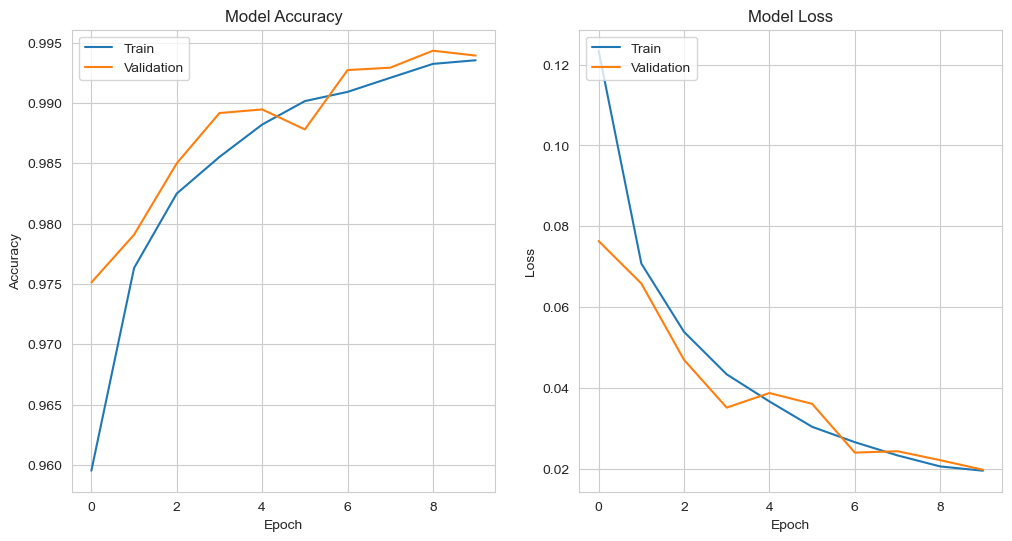

In [58]:
import matplotlib.pyplot as plt

# Extract final values for training
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
final_train_recall = history.history['recall_4'][-1] * 100  # Convert to percentage
final_train_auc = history.history['auc_4'][-1] * 100  # Convert to percentage

# Extract final values for validation
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
final_val_recall = history.history['val_recall_4'][-1] * 100  # Convert to percentage
final_val_auc = history.history['val_auc_4'][-1] * 100  # Convert to percentage

# Print the final training results
print("Final Training Results:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_accuracy:.2f}%")
print(f"Recall: {final_train_recall:.2f}%")
print(f"AUC-ROC: {final_train_auc:.2f}%")

# Print the final validation results
print("\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_accuracy:.2f}%")
print(f"Recall: {final_val_recall:.2f}%")
print(f"AUC-ROC: {final_val_auc:.2f}%")

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [59]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_recall, test_auc = model.evaluate(x_test, y_test, verbose=0)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')
print(f'Test AUC: {test_auc * 100:.2f}%')

Test Loss: 9.81102180480957
Test Accuracy: 98.47%
Test Recall: 81.87%
Test AUC: 93.48%


### RNN (LSTM)

In [60]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.optimizers import Adam
from keras.metrics import Recall, AUC

# Create a Sequential model for the Recurrent Neural Network (RNN)
model = Sequential()

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(162, 1)))

# Add another bidirectional LSTM layer
model.add(Bidirectional(LSTM(32)))

# Add fully connected layers with ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Add output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer, binary crossentropy loss, and additional metrics excluding precision
model.compile(optimizer=Adam(lr=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), AUC()])

# Train the model on the training data
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
# test_loss, test_accuracy, test_recall, test_auc = model.evaluate(x_test, y_test)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Recall: {test_recall}, Test AUC: {test_auc}")

Epoch 1/10
2492/2492 [==============================] - 376s 149ms/step - loss: 0.2150 - accuracy: 0.9287 - recall_5: 0.9149 - auc_5: 0.9665 - val_loss: 0.1975 - val_accuracy: 0.9368 - val_recall_5: 0.9377 - val_auc_5: 0.9744
Epoch 2/10
2492/2492 [==============================] - 350s 140ms/step - loss: 0.1884 - accuracy: 0.9395 - recall_5: 0.9384 - auc_5: 0.9730 - val_loss: 0.1740 - val_accuracy: 0.9417 - val_recall_5: 0.9535 - val_auc_5: 0.9793
Epoch 3/10
2492/2492 [==============================] - 348s 140ms/step - loss: 0.1688 - accuracy: 0.9458 - recall_5: 0.9434 - auc_5: 0.9779 - val_loss: 0.1675 - val_accuracy: 0.9456 - val_recall_5: 0.9410 - val_auc_5: 0.9798
Epoch 4/10
2492/2492 [==============================] - 358s 144ms/step - loss: 0.1476 - accuracy: 0.9532 - recall_5: 0.9497 - auc_5: 0.9831 - val_loss: 0.1344 - val_accuracy: 0.9561 - val_recall_5: 0.9448 - val_auc_5: 0.9879
Epoch 5/10
2492/2492 [==============================] - 345s 138ms/step - loss: 0.1271 - accurac

In [61]:
# Print the keys of history.history
print("Available Metrics in Training History:", history.history.keys())

Available Metrics in Training History: dict_keys(['loss', 'accuracy', 'recall_5', 'auc_5', 'val_loss', 'val_accuracy', 'val_recall_5', 'val_auc_5'])


Final Training Results:
Loss: 0.0793
Accuracy: 97.36%
Recall: 97.54%
AUC-ROC: 99.51%

Final Validation Results:
Loss: 0.0740
Accuracy: 97.67%
Recall: 97.75%
AUC-ROC: 99.53%


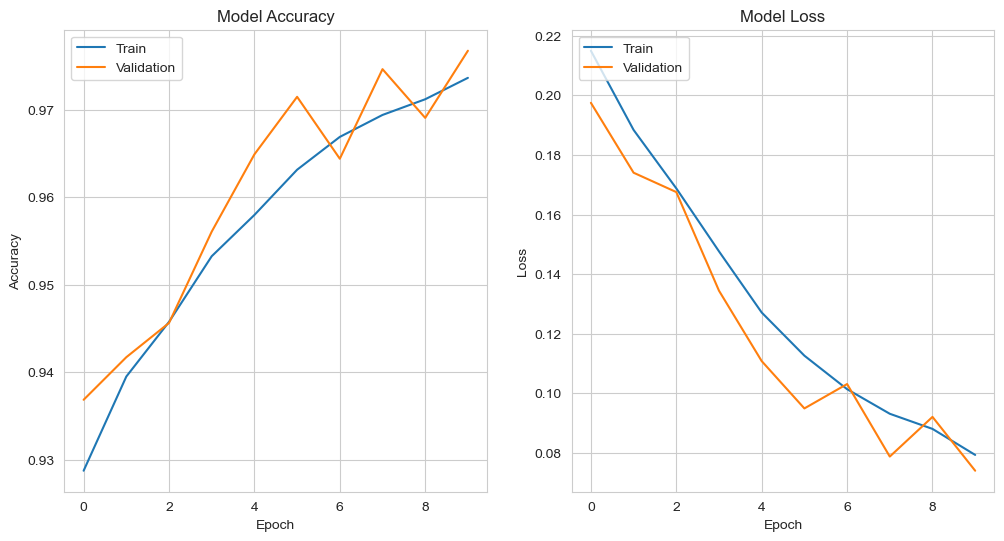

In [63]:
import matplotlib.pyplot as plt

# Extract final values for training
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
final_train_recall = history.history['recall_5'][-1] * 100  # Convert to percentage
final_train_auc = history.history['auc_5'][-1] * 100  # Convert to percentage

# Extract final values for validation
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
final_val_recall = history.history['val_recall_5'][-1] * 100  # Convert to percentage
final_val_auc = history.history['val_auc_5'][-1] * 100  # Convert to percentage

# Print the final training results
print("Final Training Results:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_accuracy:.2f}%")
print(f"Recall: {final_train_recall:.2f}%")
print(f"AUC-ROC: {final_train_auc:.2f}%")

# Print the final validation results
print("\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_accuracy:.2f}%")
print(f"Recall: {final_val_recall:.2f}%")
print(f"AUC-ROC: {final_val_auc:.2f}%")

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [64]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_recall, test_auc = model.evaluate(x_test, y_test, verbose=0)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')
print(f'Test AUC: {test_auc * 100:.2f}%')

Test Loss: 0.110493004322052
Test Accuracy: 96.51%
Test Recall: 89.07%
Test AUC: 96.71%


### RNN (LSTM) TUning Hyperparamaeters

In [66]:
from keras.layers import LSTM, Bidirectional, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import Recall, AUC

# Create a Sequential model for the RNN
model = Sequential()

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(162,1)))

# Add another bidirectional LSTM layer with fewer units
model.add(Bidirectional(LSTM(64)))

# Add fully connected layers with ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Add output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer (adjusted learning rate), binary crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(lr=0.005), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), AUC()])

# Train the model on the training data with adjusted batch size
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.25)

# Evaluate the model on the testing data
#loss, accuracy = model.evaluate(x_test, y_test)
#print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/15
1169/1169 [==============================] - 556s 469ms/step - loss: 0.2152 - accuracy: 0.9282 - recall_7: 0.9229 - auc_7: 0.9664 - val_loss: 0.1879 - val_accuracy: 0.9360 - val_recall_7: 0.9295 - val_auc_7: 0.9735
Epoch 2/15
1169/1169 [==============================] - 551s 472ms/step - loss: 0.1828 - accuracy: 0.9417 - recall_7: 0.9441 - auc_7: 0.9743 - val_loss: 0.1756 - val_accuracy: 0.9436 - val_recall_7: 0.9540 - val_auc_7: 0.9793
Epoch 3/15
1169/1169 [==============================] - 552s 472ms/step - loss: 0.1608 - accuracy: 0.9477 - recall_7: 0.9479 - auc_7: 0.9814 - val_loss: 0.1444 - val_accuracy: 0.9524 - val_recall_7: 0.9475 - val_auc_7: 0.9858
Epoch 4/15
1169/1169 [==============================] - 548s 469ms/step - loss: 0.1449 - accuracy: 0.9515 - recall_7: 0.9488 - auc_7: 0.9854 - val_loss: 0.1383 - val_accuracy: 0.9555 - val_recall_7: 0.9580 - val_auc_7: 0.9870
Epoch 5/15
1169/1169 [==============================] - 551s 472ms/step - loss: 0.1313 - accurac

ValueError: too many values to unpack (expected 2)

In [67]:
# Print the keys of history.history
print("Available Metrics in Training History:", history.history.keys())

Available Metrics in Training History: dict_keys(['loss', 'accuracy', 'recall_7', 'auc_7', 'val_loss', 'val_accuracy', 'val_recall_7', 'val_auc_7'])


Final Training Results:
Loss: 0.0827
Accuracy: 97.24%
Recall: 97.48%
AUC-ROC: 99.48%

Final Validation Results:
Loss: 0.0967
Accuracy: 97.32%
Recall: 97.41%
AUC-ROC: 99.22%


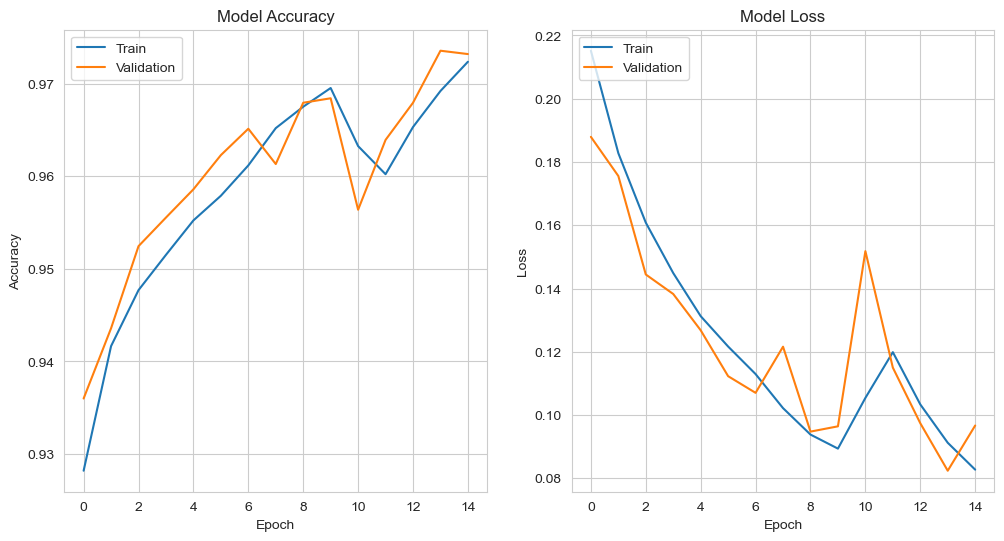

In [69]:
import matplotlib.pyplot as plt

# Extract final values for training
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
final_train_recall = history.history['recall_7'][-1] * 100  # Convert to percentage
final_train_auc = history.history['auc_7'][-1] * 100  # Convert to percentage

# Extract final values for validation
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
final_val_recall = history.history['val_recall_7'][-1] * 100  # Convert to percentage
final_val_auc = history.history['val_auc_7'][-1] * 100  # Convert to percentage

# Print the final training results
print("Final Training Results:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_accuracy:.2f}%")
print(f"Recall: {final_train_recall:.2f}%")
print(f"AUC-ROC: {final_train_auc:.2f}%")

# Print the final validation results
print("\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_accuracy:.2f}%")
print(f"Recall: {final_val_recall:.2f}%")
print(f"AUC-ROC: {final_val_auc:.2f}%")

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [70]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_recall, test_auc = model.evaluate(x_test, y_test, verbose=0)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')
print(f'Test AUC: {test_auc * 100:.2f}%')

Test Loss: 0.10636764764785767
Test Accuracy: 96.22%
Test Recall: 92.00%
Test AUC: 98.44%
